In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import json
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle


from shapely.geometry import Point, LineString, Polygon

import numpy as np
from stl import mesh
from shapely.geometry import Polygon
from shapely.ops import unary_union

In [2]:
#%pip install shapely
#%pip install numpy-stl

In [2]:
#save STL file from polygon dictionary

# Function to convert 2D polygon to 3D mesh by adding thickness
def polygon_to_3d_mesh(polygon, thickness=1.0):
    # Get the exterior coordinates of the 2D polygon
    exterior_coords = list(polygon.exterior.coords)
    
    # Create vertices for the top and bottom of the 3D shape
    top_vertices = [(x, y, thickness) for x, y in exterior_coords]
    bottom_vertices = [(x, y, 0) for x, y in exterior_coords]
    
    # Vertices array: two sets of vertices (top and bottom)
    vertices = np.array(top_vertices + bottom_vertices)
    
    # Number of points in the polygon
    n = len(exterior_coords)
    
    # Create faces (triangles) connecting the top and bottom surfaces
    faces = []
    
    # Create side walls
    for i in range(n):
        next_i = (i + 1) % n
        faces.append([i, next_i, n + next_i])   # Top to bottom
        faces.append([i, n + next_i, n + i])    # Bottom to top
    
    # Create top and bottom surfaces
    for i in range(1, n - 1):
        faces.append([0, i+1, i ])#[0, i, i + 1])             # Top face
        faces.append([n, n + i, n + i+1]) #[n, n + i, n + i + 1])     # Bottom face

    # Convert faces to NumPy array
    faces = np.array(faces)
    
    # Create mesh object
    polygon_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    
    for i, face in enumerate(faces):
        for j in range(3):
            polygon_mesh.vectors[i][j] = vertices[face[j], :]
    
    return polygon_mesh

def merge_3d_meshes(mesh_list):
    # List to hold the vertices and faces of the merged mesh
    vertices = []
    faces = []
    
    # Variable to track the current offset for the face indices
    vertex_offset = 0
    
    # Iterate over each mesh and extract its vertices and faces
    for m in mesh_list:
        # Extract the vertices and faces of the current mesh
        current_vertices = m.vectors.reshape(-1, 3)  # Each face is a set of 3 vertices
        current_faces = np.arange(len(current_vertices)).reshape(-1, 3)
        
        # Append the vertices, and adjust the face indices by the current offset
        vertices.append(current_vertices)
        faces.append(current_faces + vertex_offset)
        
        # Update the vertex offset for the next mesh
        vertex_offset += len(current_vertices)
    
    # Concatenate all the vertices and faces into a single array
    vertices = np.vstack(vertices)
    faces = np.vstack(faces)
    
    # Create a new merged mesh
    merged_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    
    # Fill the new mesh with the vertices and faces
    for i, face in enumerate(faces):
        for j in range(3):
            merged_mesh.vectors[i][j] = vertices[face[j], :]
    
    return merged_mesh

def save_stl(poly_dict, out_plane_thickness, name, f_x_max=1, f_y_max = 1, f_x_min=1, f_y_min = 1, frame_thickness = None):
    mesh_list = []
    for k,v in poly_dict.items():
        p = [] 
        for j in v:
            try: 
                p.append((float(j[0]), float(j[1])))
            except:
                None
        
        mesh_list.append(polygon_to_3d_mesh(Polygon(p), thickness=out_plane_thickness))
    
    if frame_thickness != None:
        t = frame_thickness
        #bottom = Polygon([ (0,0-t), (0,0),(f_x,0),(f_x,0-t)])
        #top = Polygon([(0,f_y),(0,f_y+t), (f_x,f_y+t), (f_x,f_y)])
        bottom = Polygon([ (f_x_min,f_y_min-t), (f_x_min,f_y_min),(f_x_max,f_y_min),(f_x_max,f_y_min-t)])
        top = Polygon([(f_x_min,f_y_max),(f_x_min,f_y_max+t), (f_x_max,f_y_max+t), (f_x_max,f_y_max)])
        
        #right = Polygon([(f_x,0-t), (f_x,f_y+t), (f_x+t,f_y+t), (f_x+t,0-t)])
        #left = Polygon([(0-t,0-t),(0-t,f_y+t), (0,f_y+t), (0,0-t)])

        f = [bottom,top]#,  right, left]

        for f_ in f:            
            mesh_list.append(polygon_to_3d_mesh(f_, thickness=out_plane_thickness))

    merged_mesh = merge_3d_meshes(mesh_list)

    # Save the merged mesh as an STL file   
    merged_mesh.save(name)

# Hex lattice

In [3]:
#generate a hexagonal lattice
def hexagonal_lattice(n, a = 1):

    a1 = a*np.array([1,0])
    a2 = a*np.array([1/2, np.sqrt(3)/2])
    v1 = a*np.array([1/2, np.sqrt(3)/6])
    v2 = a*np.array([1, np.sqrt(3)/3])

    points = []
    for i in range(n):
        for j in range(n):
            points.append(((i*a1+j*a2) + v1))
            points.append(((i*a1+j*a2) + v2))
    
    return np.array(points)

def hexagonal_lattice_square(n,a, x1,x2,y1, y2):

    points = hexagonal_lattice(n,a)
    #select pooints where x1 < x < x2 and y1 < y < y2
    points = points[(points[:,0] > x1) & (points[:,0] < x2) & (points[:,1] > y1) & (points[:,1] < y2)]
    
    #translate the points to the origin
    points = points - np.array([points[:,0].min(), points[:,1].min()+y1])

    #scale the points to the unit square
    max_s = points[:,0].max()
    if max_s < points[:,1].max():
        max_s = points[:,1].max()

    points[:,0] = points[:,0]/max_s#points[:,0].max()
    points[:,1] = points[:,1]/max_s#points[:,1].max()

    #points[:,0] = points[:,0]/points[:,0].max()
    #points[:,1] = points[:,1]/points[:,1].max()

    return np.array(points)

def get_edges(points, r):
    edges = []
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            d = np.linalg.norm(points[i]-points[j])
            if d < r+1e-7:
                edges.append([i,j])

    return np.array(edges)



In [4]:
unit = 1

hl = hexagonal_lattice(n = 30, a = unit)
#hls = hexagonal_lattice_square(n = 35, a=unit, x1=12, x2=27,y1=0, y2=15)
hls = hexagonal_lattice_square(n = 70, a=unit, x1=15, x2=39,y1=0, y2=24)

edges = get_edges(points = hls, r = unit*np.sqrt(3)/3/23) #unit*np.sqrt(3)/3/14) 

5
54 0.05085714285714286


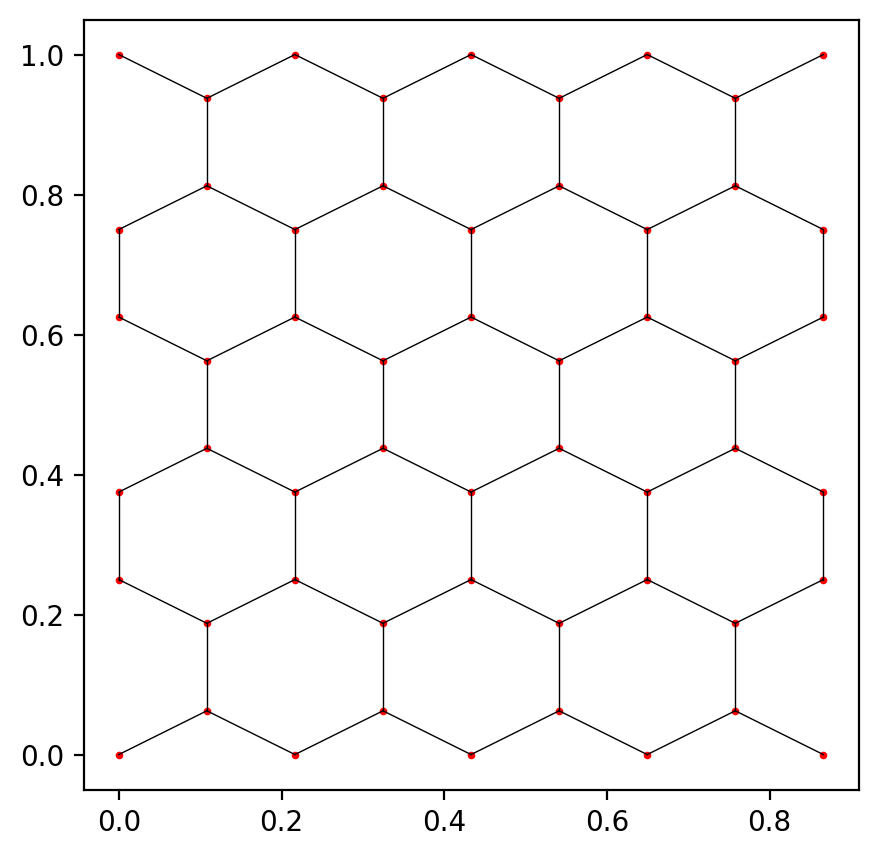

7
104 0.03471631205673762


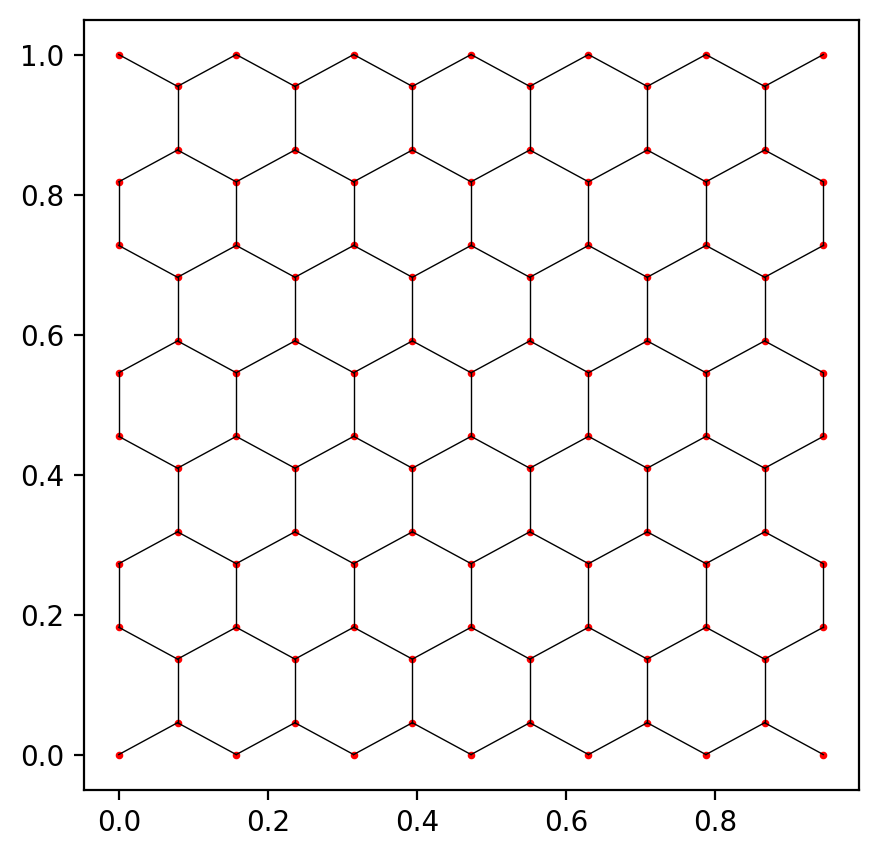

12
322 0.019474835886214438


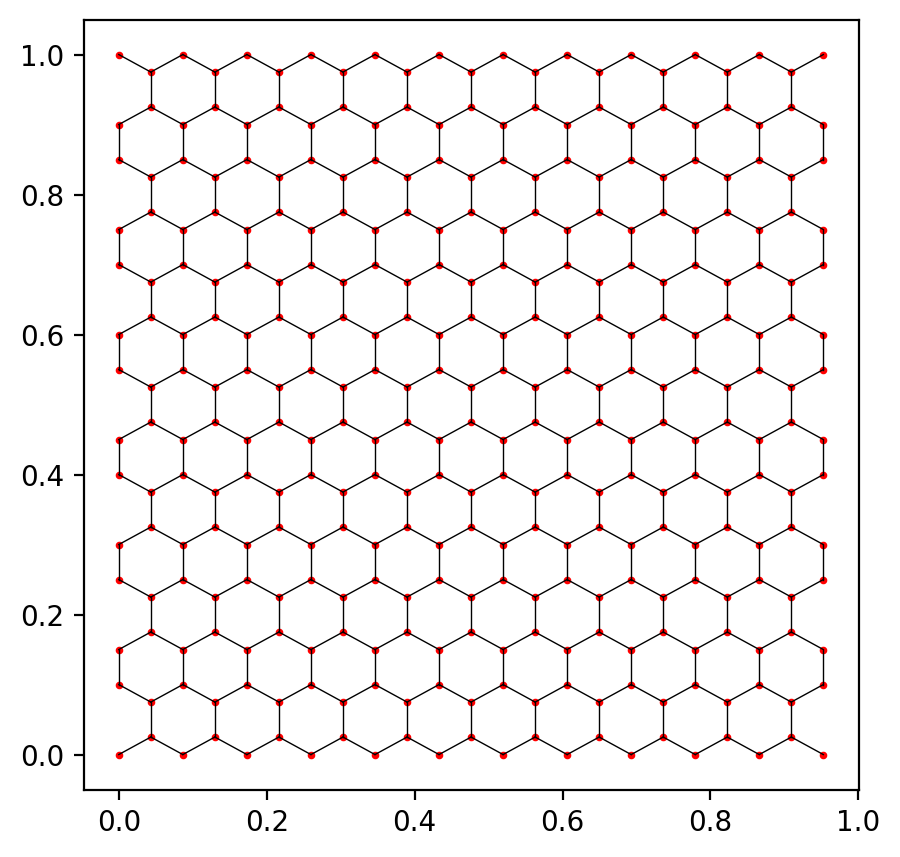

19
814 0.012067796610169473


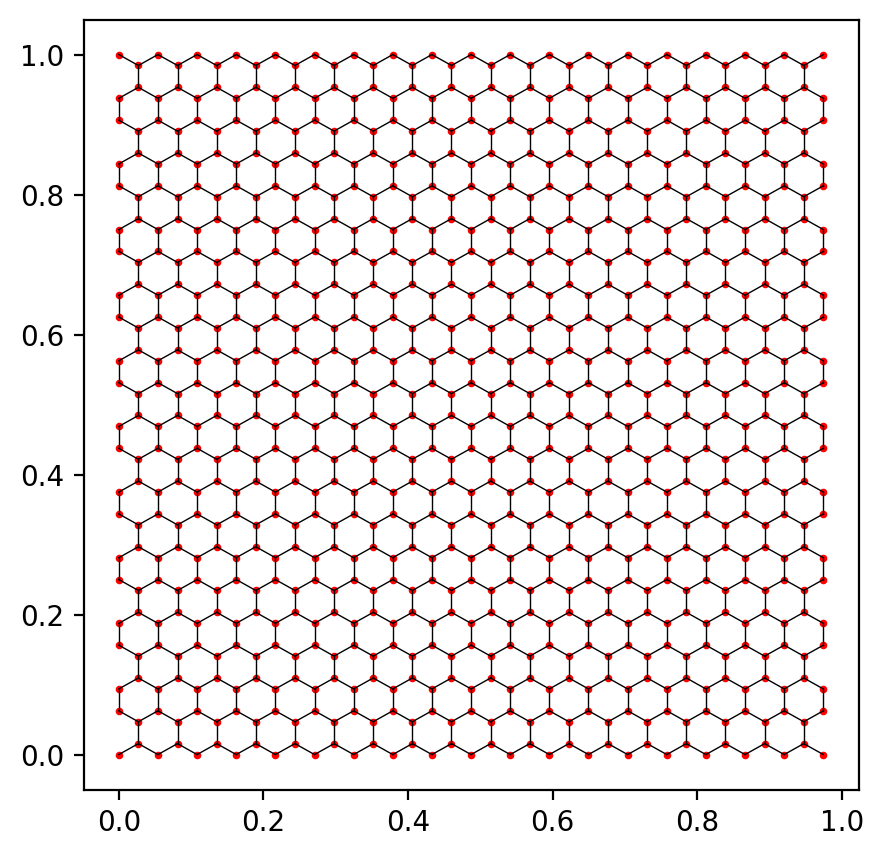

21
984 0.010883997204751911


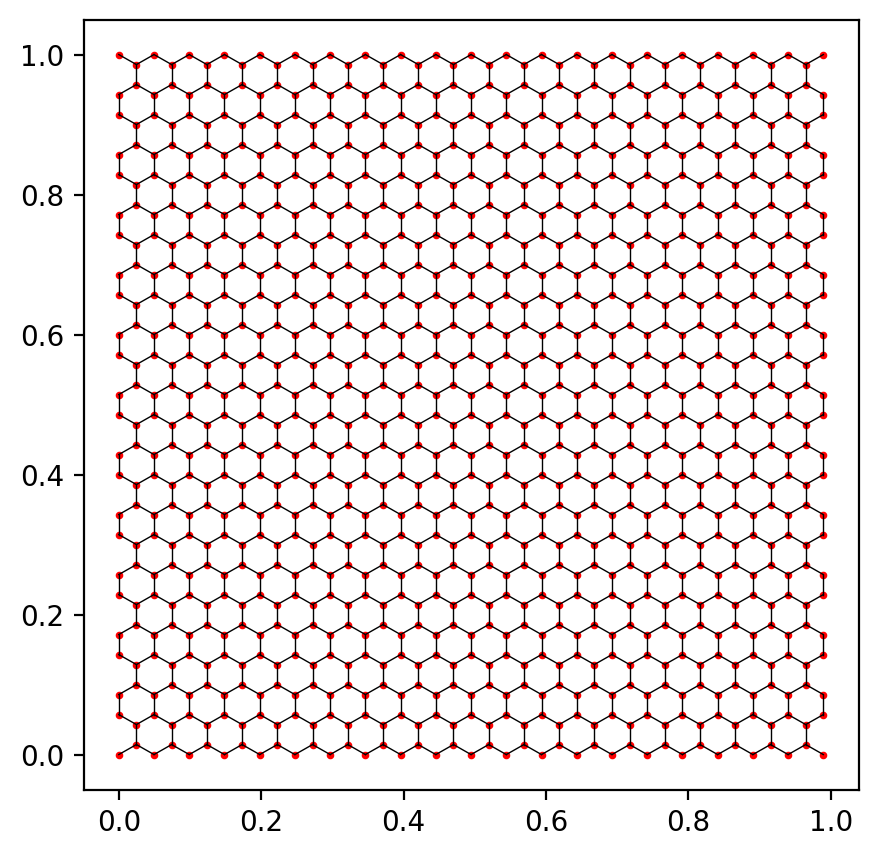

24
1316 0.00949271592091569


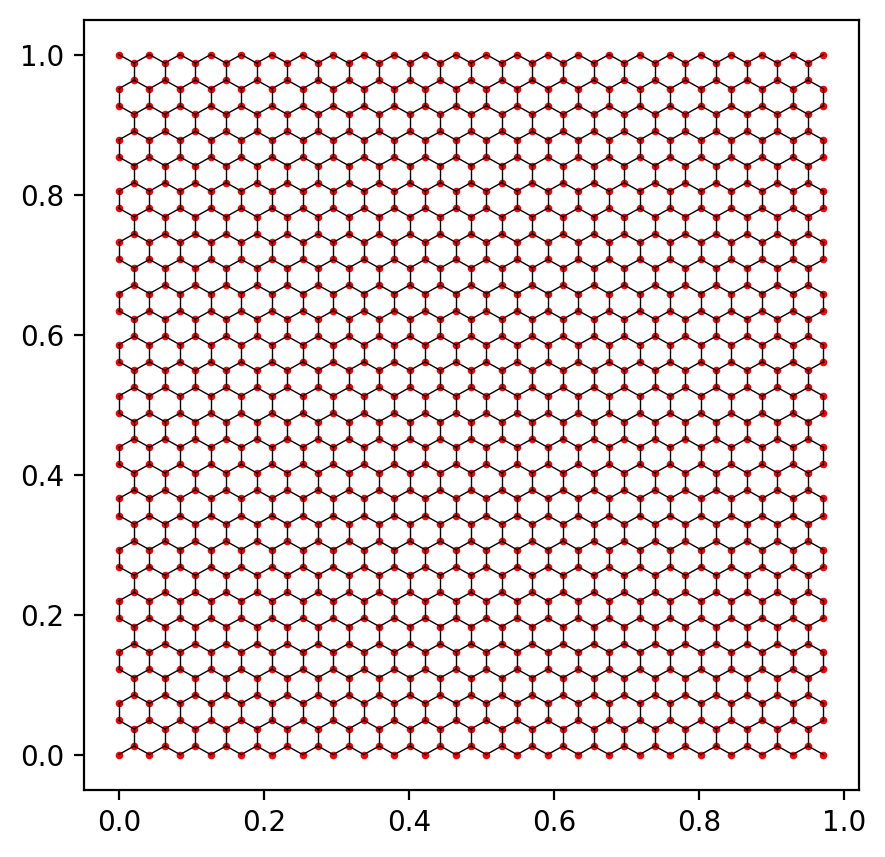

In [6]:
# different unit cells
unit_cells = { 3:{'pts':None, 'edges':None}, 5:{'pts':None, 'edges':None}, 10:{'pts':None, 'edges':None},
             17:{'pts':None, 'edges':None}, 19:{'pts':None, 'edges':None}, 22:{'pts':None, 'edges':None}}



for un in unit_cells:
    unit = 1
    print(un+2)
    hls = hexagonal_lattice_square(n = 70, a=unit, x1=15, x2=15+un+2,y1=0, y2=un+2)
    edges = get_edges(points = hls, r = unit*np.sqrt(3)/3/un)
    unit_cells[un]['pts'] = hls
    unit_cells[un]['edges'] = edges

    #edge length
    edge_length = hls[edges[:,0]] - hls[edges[:,1]]
    edge_length = np.linalg.norm(edge_length, axis=1)

    print(len(hls), 0.445 / len(edges)/ edge_length[0])
    avg_thickness = 0.445 / (len(edges))/ edge_length[0]
    unit_cells[un]['avg_thickness'] = avg_thickness



    fig,ax1 = plt.subplots(figsize=(5,5))

    plt.scatter(hls[:,0], hls[:,1], c = 'red', s = 3);

    for e in edges:
        plt.plot([hls[e[0]][0], hls[e[1]][0]], [hls[e[0]][1], hls[e[1]][1]], c = 'black', linewidth = 0.5)
    
    plt.show()

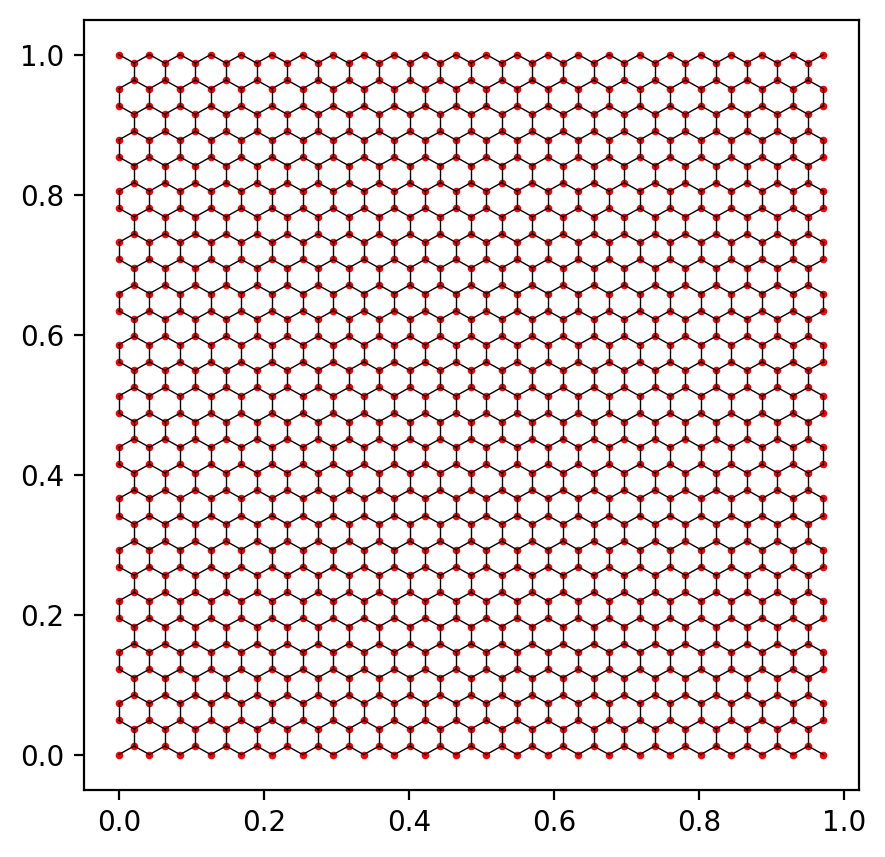

In [7]:
fig,ax1 = plt.subplots(figsize=(5,5))

plt.scatter(hls[:,0], hls[:,1], c = 'red', s = 3);

for e in edges:
    plt.plot([hls[e[0]][0], hls[e[1]][0]], [hls[e[0]][1], hls[e[1]][1]], c = 'black', linewidth = 0.5)

In [7]:
#create a polygon  from edges
def extend_line(line, extension_length):
    """
    Extend a line by a specified length on both ends.
    """
    # Get coordinates of line endpoints
    x1, y1 = line.coords[0]
    x2, y2 = line.coords[-1]
    
    # Calculate direction vector
    dx = x2 - x1
    dy = y2 - y1
    
    # Normalize direction vector
    length = np.sqrt(dx*dx + dy*dy)
    dx = dx / length
    dy = dy / length
    
    # Calculate new endpoints
    new_x1 = x1 - dx * extension_length
    new_y1 = y1 - dy * extension_length
    new_x2 = x2 + dx * extension_length
    new_y2 = y2 + dy * extension_length
    
    # Create new extended line
    return LineString([(new_x1, new_y1), (new_x2, new_y2)])


def edge_thickness(edges, hls, thickness):
    polygon_dict = {}
    area = []

    fig,ax1 = plt.subplots(figsize=(5,5))

    for en, e in enumerate(edges):

        x1 = hls[e[0]][0]
        y1= hls[e[0]][1]

        x2 = hls[e[1]][0]
        y2 = hls[e[1]][1]

        #createa Point object fro x1,y1 and x2,y2
        p_e = Point(x1,y1)
        p_s = Point(x2,y2)

        line = LineString([(x1,y1),(x2,y2)])

        line_1 = extend_line(line, thickness/np.sqrt(3))

        line_2 = extend_line(line, thickness/np.sqrt(3)/2)

        #t = thickness *np.sqrt(3)/8

        #get a points t distance from line end points on the line
        p1 = Point(line_2.coords[0])
        p2 = Point(line_2.coords[-1])

        #print(p1, p2)

        #get normal vector to the line from p1 
        n = np.array([y2-y1, x1-x2])
        n = n/np.linalg.norm(n)
        p1_up = np.array(p1.coords[0]) + thickness*n/2
        p1_down = np.array(p1.coords[0]) - thickness*n/2
        
        p2_up = np.array(p2.coords[0]) + thickness*n/2
        p2_down = np.array(p2.coords[0]) - thickness*n/2

        #define a polygon with p1, p1_up, p2_up, p2, p2_down, p1_down
        polygon = Polygon([ line_1.coords[0], p1_up, p2_up, line_1.coords[-1], p2_down, p1_down])
        
        #order polygon vertices to generate a convex polygon
        polygon = Polygon(polygon.exterior.coords[:])

        
        if polygon.is_valid:
            convex_polygon = polygon.convex_hull
        
        #get the polygon coordinates
        polygon_dict[en] = convex_polygon.exterior.coords[:]
        
        area += [convex_polygon.area]
        #plot the polygon
        plt.fill(*convex_polygon.exterior.xy, c = 'red', linewidth = .01,alpha = 0.5)

    return polygon_dict, np.sum(area)

    

0.4016626501577422


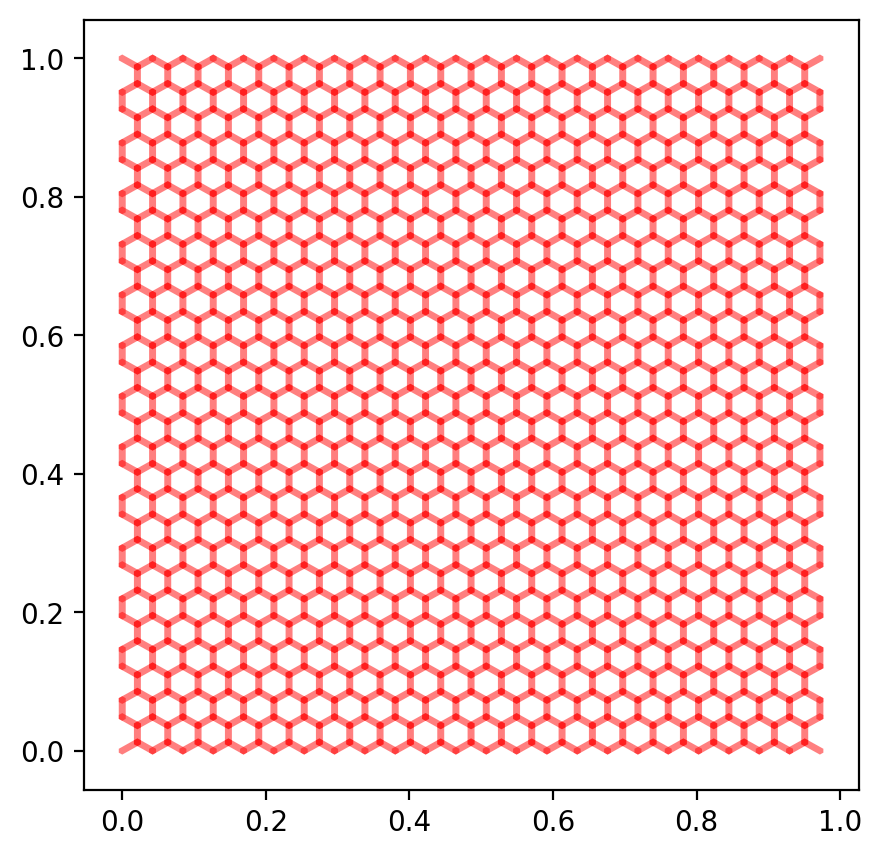

In [8]:
#[0.0045:20 , 0.007:30, 0.0096:40, 0.0125:50, 0.0155:60, 0.019:70]
t_ = 0.0096
structure, area = edge_thickness(edges, hls, thickness = t_)

new_area = area - len(edges)*np.sqrt(3)*(t_**2)+len(hls)*np.sqrt(3)*(t_**2)/2

print(new_area)

In [10]:
import networkx as nx

def filter_largest_component_from_edges(edge_list):
    # Create graph from edge list
    G = nx.Graph(edge_list)   
    # Find connected components
    components = list(nx.connected_components(G))
    # Select largest component
    largest_component = max(components, key=len)
    # Filter edges in largest component
    filtered_edges = [ (u, v) for (u, v) in edge_list if u in largest_component and v in largest_component]
    
    return filtered_edges#

sample_hex_r0_l0p004_v0_d20
sample_hex_r0_l0p007_v0_d30
sample_hex_r0_l0p01_v0_d40
sample_hex_r0_l0p013_v0_d50
sample_hex_r0_l0p015_v0_d60
sample_hex_r0_l0p019_v0_d70


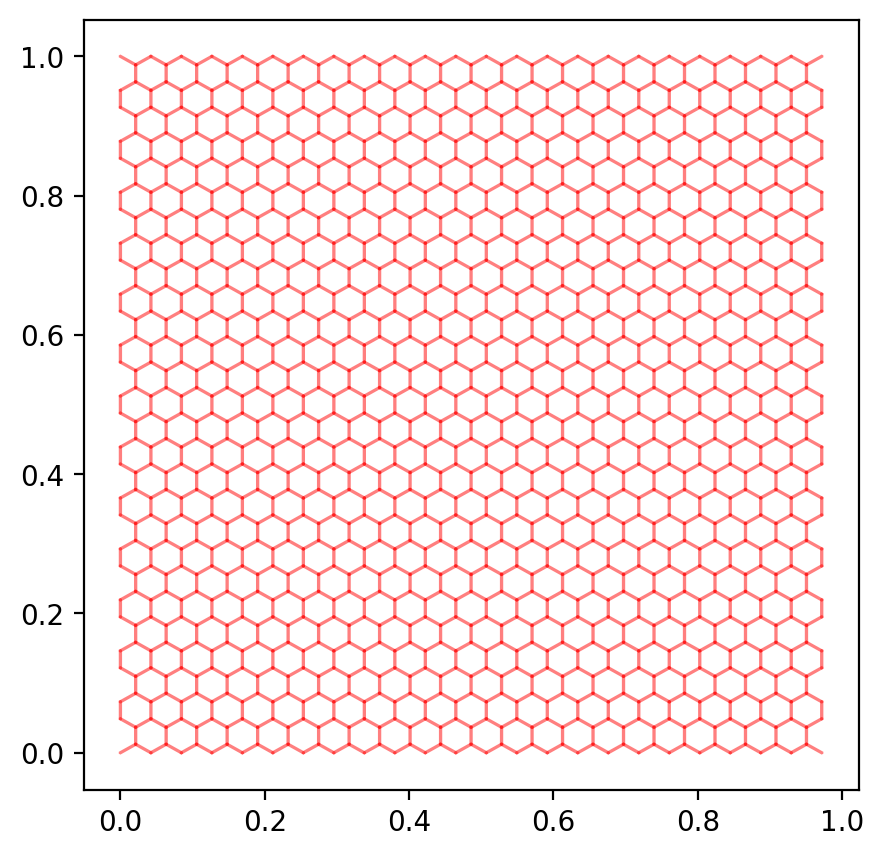

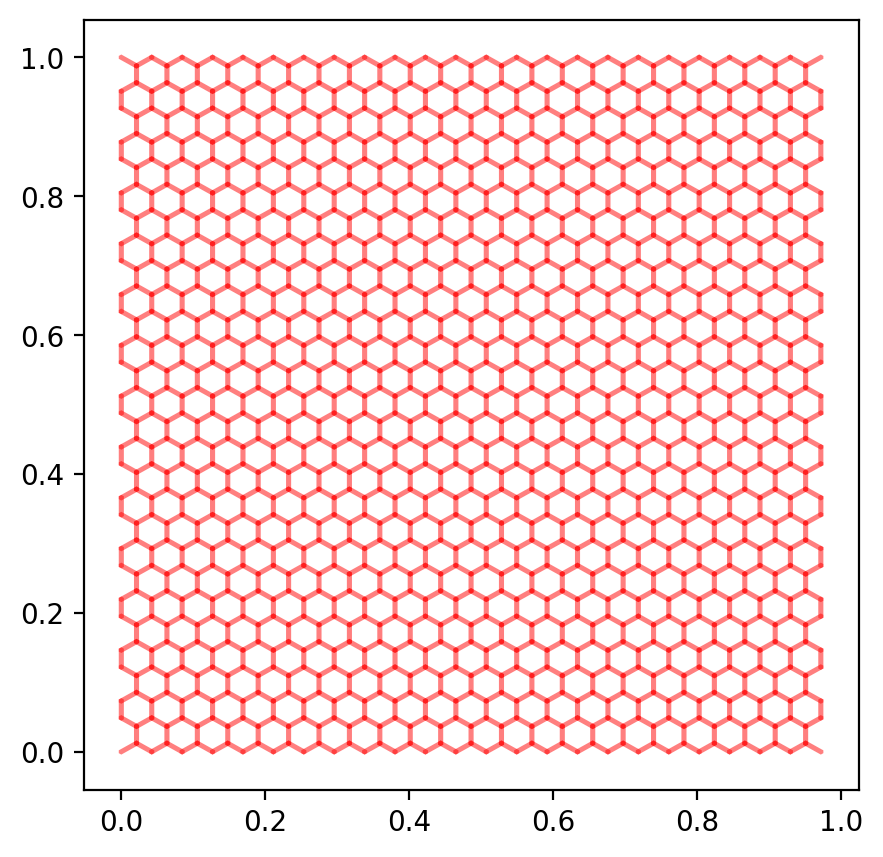

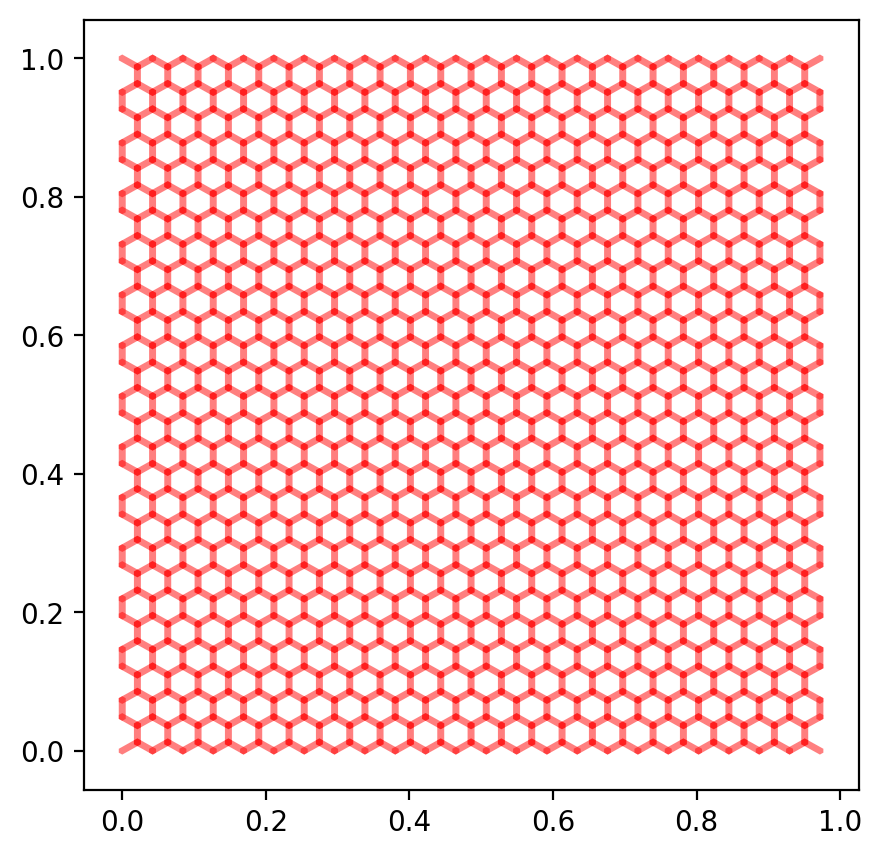

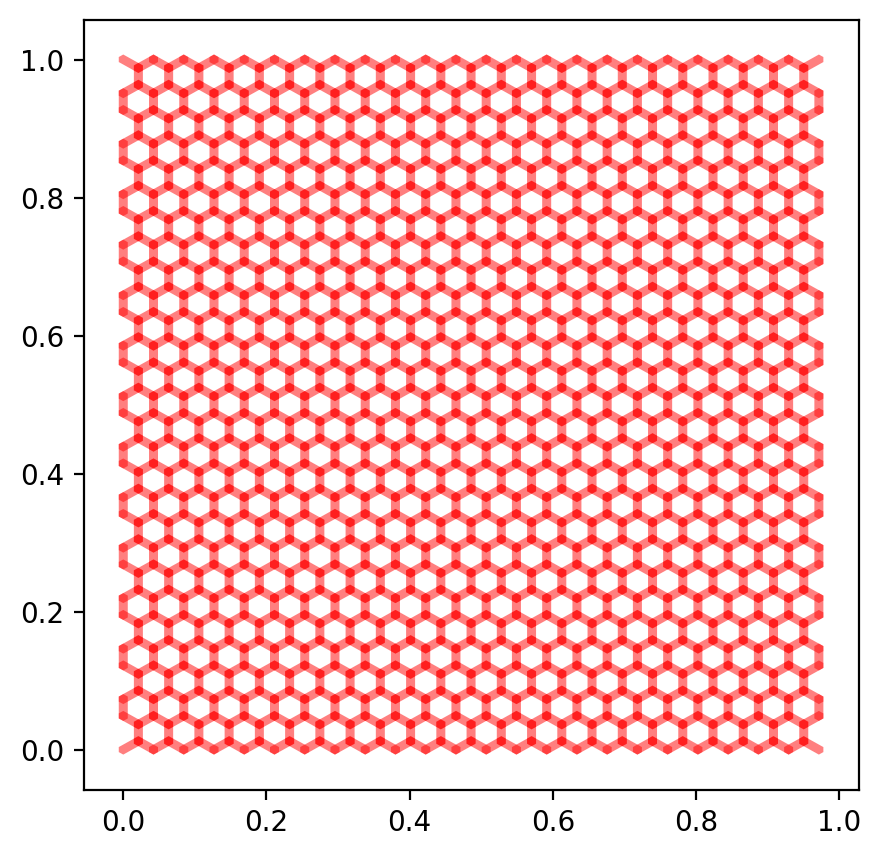

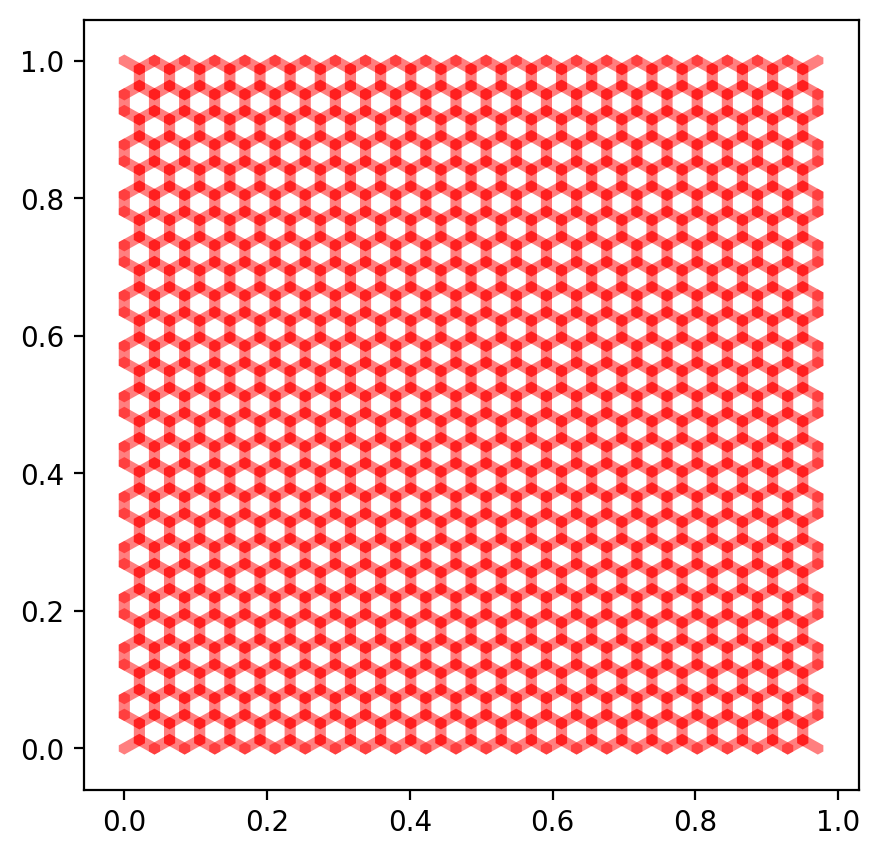

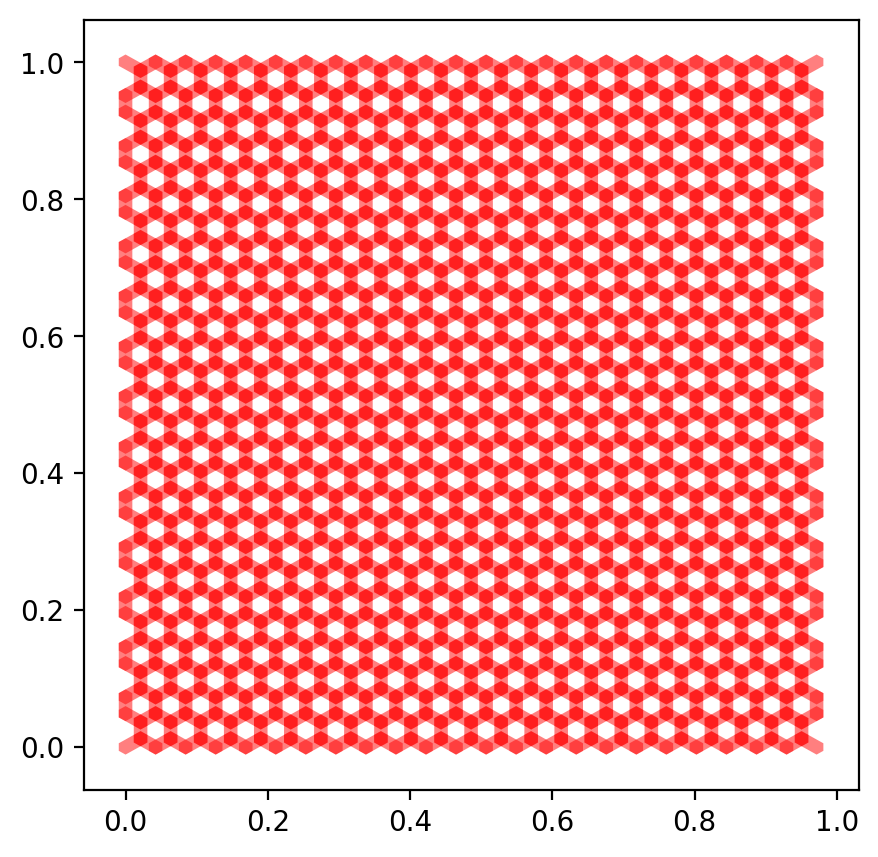

In [ ]:
def generate_hex(hls,edges, keep_frac, thickness):

    edges_tuple = [tuple(e) for e in edges]
    #boundary edges where x = 0 or x = 1 or y = 0 or y = 1
    boundary_edges = []
    for e in edges_tuple:
        if hls[e[0]][0] == 0 or hls[e[0]][0] == 1 or hls[e[0]][1] == 0 or hls[e[0]][1] == 1 or hls[e[1]][0] == 0 or hls[e[1]][0] == 1 or hls[e[1]][1] == 0 or hls[e[1]][1] == 1:
            boundary_edges.append(e)

    #random_edges
    random_edges = []

    for e in edges_tuple:
        if e in boundary_edges:
            random_edges.append(e)
        elif random.random() < keep_frac:
            random_edges.append(e)
    #random_edges = [e for e in edges_tuple if random.random() < 0.99]

    lcc_edges = filter_largest_component_from_edges(random_edges)

    structure, area = edge_thickness(lcc_edges, hls, thickness = thickness)

    return structure, area, lcc_edges, hls



keep_frac = [1]#[0.99, 0.95, 0.90, 0.85, 0.80]#[1, 0.99, 0.95, 0.90, 0.85, 0.80]
for replicate in [0]:# [1, 2]:
    for keep in keep_frac: 
        for avg_thickness in [0.0045 , 0.007, 0.0096, 0.0125, 0.0155, 0.019]: #[0.007, 0.0085, 0.0115, 0.0145, 0.0175]:
            structure, area, ed, pts = generate_hex(hls,  edges, keep, avg_thickness)

            new_area = area - len(edges)*np.sqrt(3)*(avg_thickness**2)+len(hls)*np.sqrt(3)*(avg_thickness**2)/2

        #print(round(new_area,2))
           #print(area,keep, avg_thickness, replicate)
            
            removal = int(100 * (1.0 - keep))
            thickness_string = str(round(avg_thickness,3)).replace(r'.', r'p')
            file_name = 'sample_hex_r'+str(int(100-keep*100))+'_l'+str(thickness_string)+'_v'+str(replicate)+'_d'+str(int(new_area*100)) #+'_' + str(removal) +'pct_' + str(replicate)
            print(file_name)
            f_x = hls[:,0].max()
            f_y = hls[:,1].max()

            path =r'./'
            
            save_stl(structure, out_plane_thickness = .25, name = path+file_name+'.stl', f_x= f_x, f_y= f_y, frame_thickness = None)#avg_thickness)

            #save the polygon_dict to a pickle file
            with open(path+'input_'+file_name + '.pkl', 'wb') as f:
                pickle.dump(structure, f, protocol=2)
            
            output = {
                'points': pts,
                'edges': ed, 
                'structure': structure,
                'thickness': avg_thickness,
            }

            with open(path+file_name + '.pkl', 'wb') as f:
                pickle.dump(output, f, protocol=2)
            
            

0.2
hex_23_th_0p0045_area_0p2
0.3
hex_23_th_0p007_area_0p3
0.4
hex_23_th_0p0096_area_0p4
0.5
hex_23_th_0p0125_area_0p5
0.6
hex_23_th_0p0155_area_0p6
0.7
hex_23_th_0p019_area_0p7


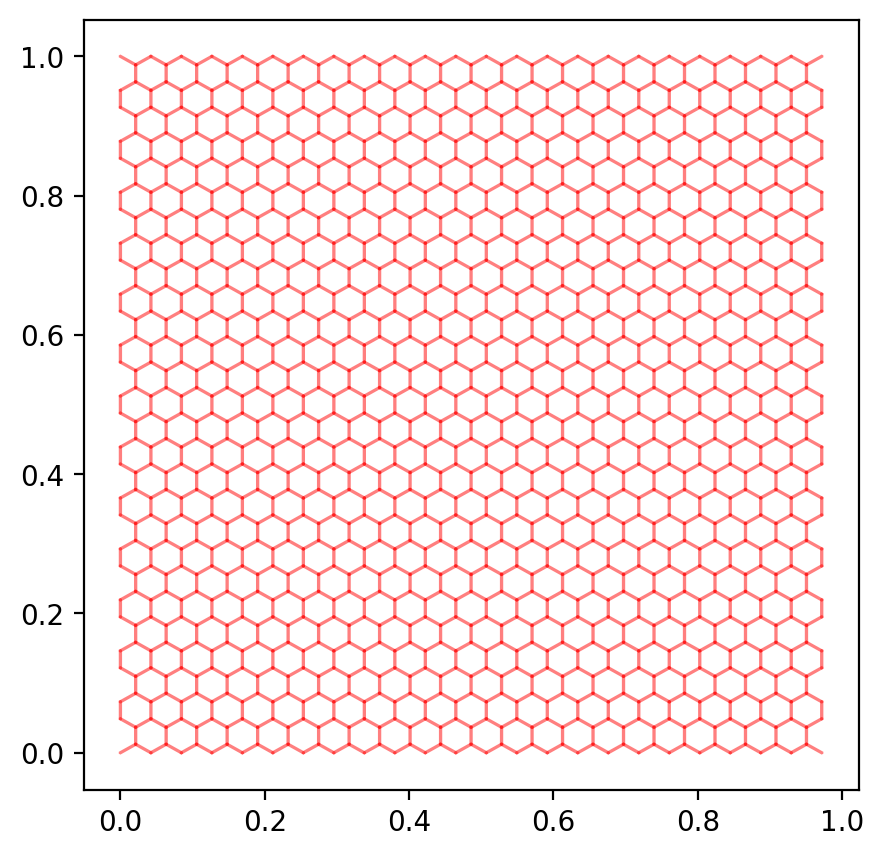

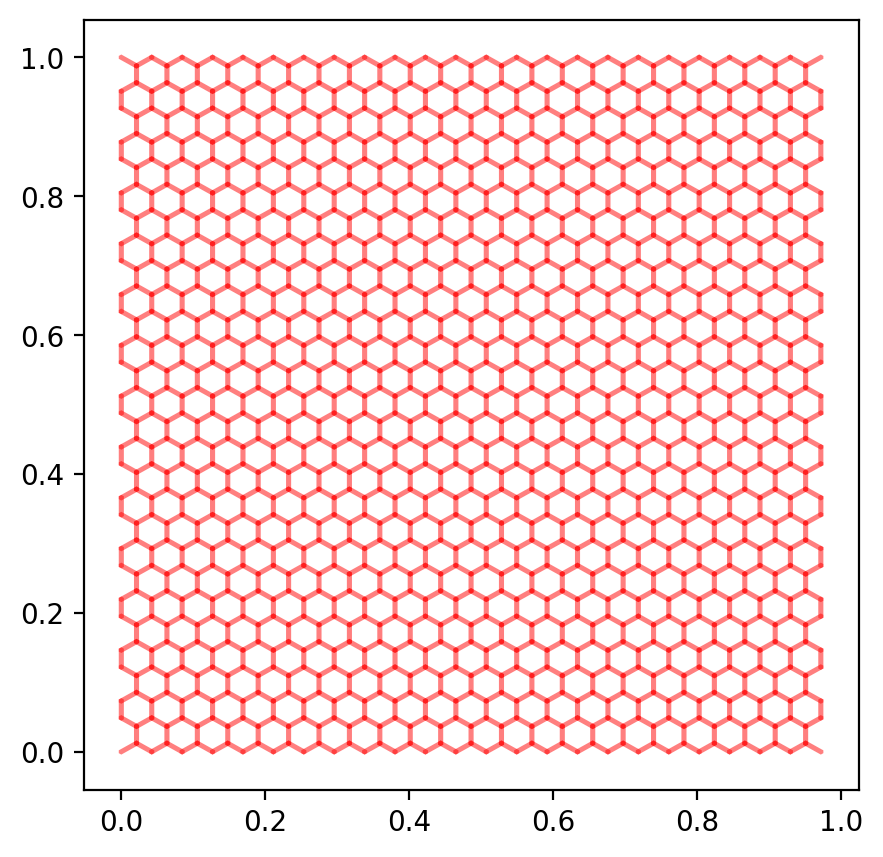

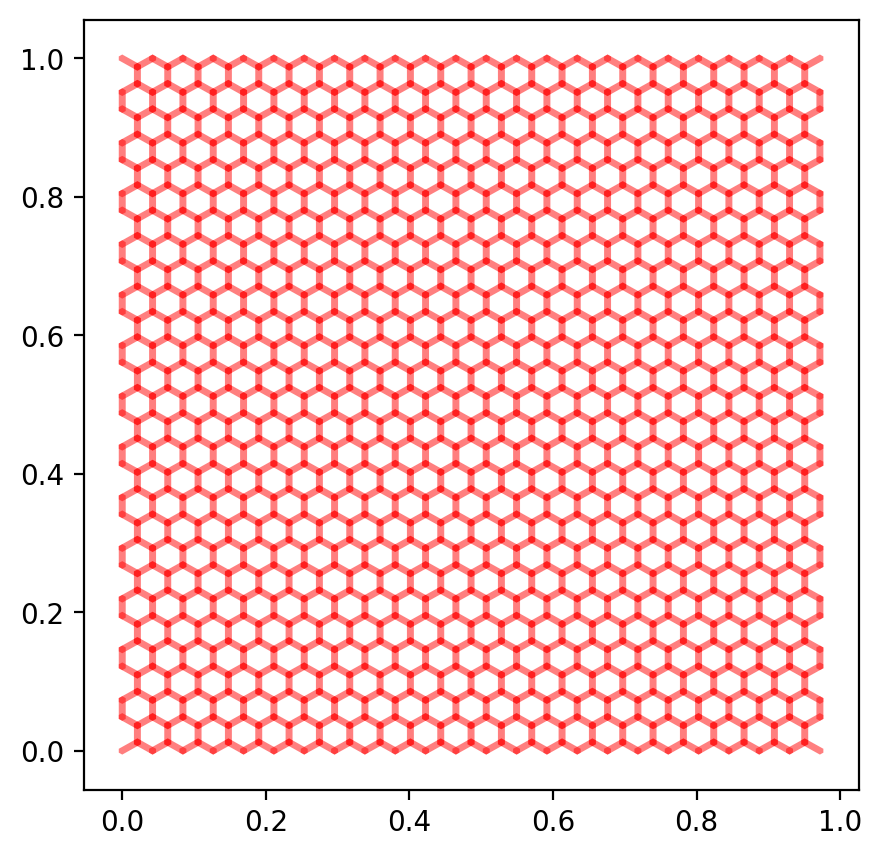

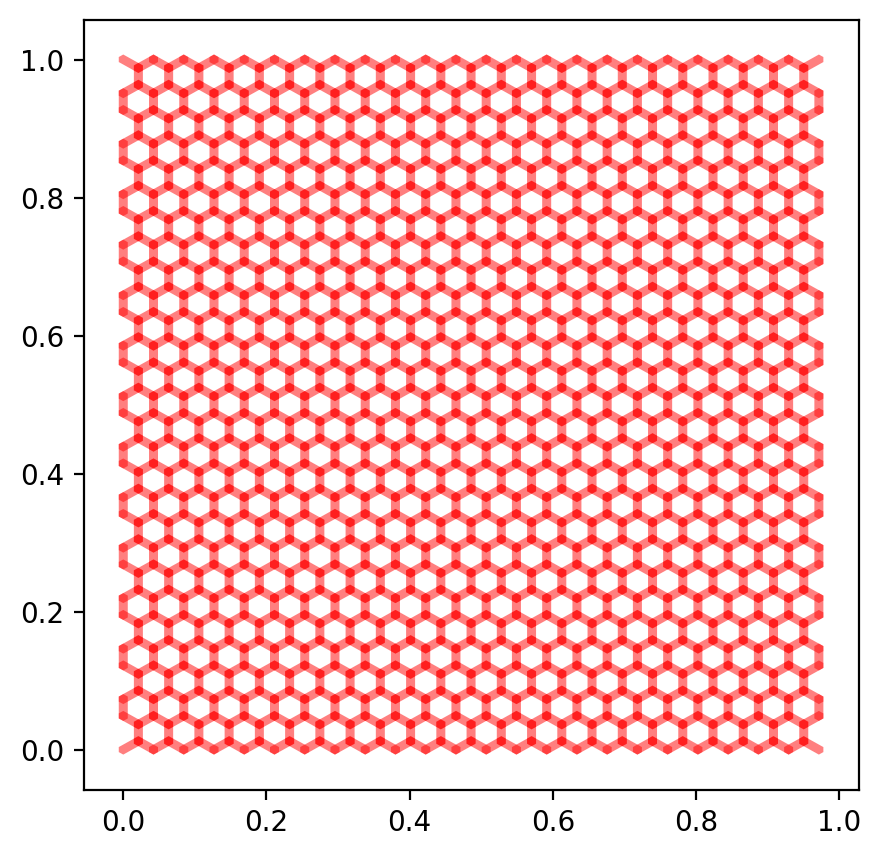

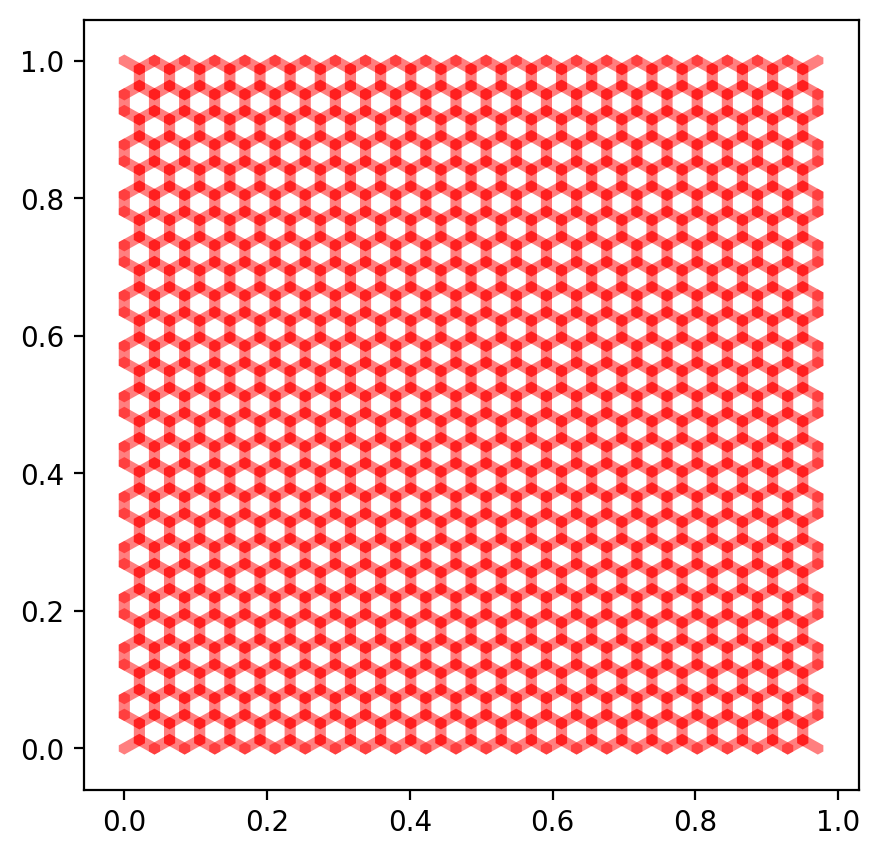

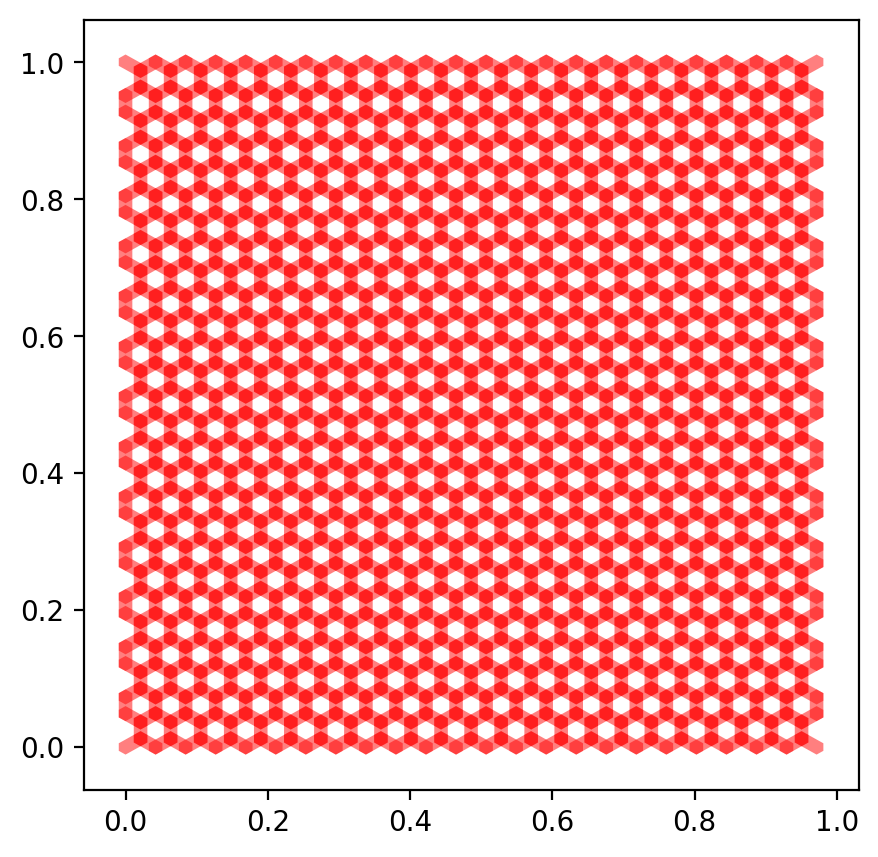

In [ ]:
def generate_hex(hls,edges, keep_frac, thickness):

    edges_tuple = [tuple(e) for e in edges]
    #boundary edges where x = 0 or x = 1 or y = 0 or y = 1
    boundary_edges = []
    for e in edges_tuple:
        if hls[e[0]][0] == 0 or hls[e[0]][0] == 1 or hls[e[0]][1] == 0 or hls[e[0]][1] == 1 or hls[e[1]][0] == 0 or hls[e[1]][0] == 1 or hls[e[1]][1] == 0 or hls[e[1]][1] == 1:
            boundary_edges.append(e)

    #random_edges
    random_edges = []

    for e in edges_tuple:
        if e in boundary_edges:
            random_edges.append(e)
        elif random.random() < keep_frac:
            random_edges.append(e)
    #random_edges = [e for e in edges_tuple if random.random() < 0.99]

    lcc_edges = filter_largest_component_from_edges(random_edges)

    structure, area = edge_thickness(lcc_edges, hls, thickness = thickness)

    return structure, area


keep_frac = [1]#[ 0.95, 0.90, 0.85, 0.80]
for replicate in [0]: #[0, 1, 2]:
    for keep in keep_frac: 
        for avg_thickness in [0.0045 , 0.007, 0.0096, 0.0125, 0.0155, 0.019]: #[0.007, 0.0085, 0.0115, 0.0145, 0.0175]:
            structure, area = generate_hex(hls,  edges, keep, avg_thickness)

            new_area = area - len(edges)*np.sqrt(3)*(avg_thickness**2)+len(hls)*np.sqrt(3)*(avg_thickness**2)/2

            print(round(new_area,2))
           #print(area,keep, avg_thickness, replicate)
            
            removal = int(100 * (1.0 - keep))
            thickness_string = str(avg_thickness).replace(r'.', r'p')
            file_name = 'hex_23_th_'+str(thickness_string)+'_area_'+str(round(new_area,2)).replace(r'.',r'p') #+'_' + str(removal) +'pct_' + str(replicate)
            print(file_name)
            f_x = hls[:,0].max()
            f_y = hls[:,1].max()

            path =r'./'
            save_stl(structure, out_plane_thickness = .25, name = path+file_name+'.stl', f_x= f_x, f_y= f_y, frame_thickness = None)#avg_thickness)


            #save the structure to a pickle file
            #t = avg_thickness       
        
            #bottom = [(0.,float(0.-t)), (float(f_x),float(0.-t)), (float(f_x),0.), (0.,0.),(0.,float(0.-t))]
            #top = [(0.,float(f_y)), (float(f_x),float(f_y)), (float(f_x),float(f_y+t)), (0.,float(f_y+t)),(0.,float(f_y))]
            #right = [(float(f_x),float(0.-t)), (float(f_x),float(f_y+t)), (float(f_x+t),float(f_y+t)), (float(f_x+t),float(0.-t)),(float(f_x),float(0.-t))]
            #left = [(0.,float(0.-t)), (0.,float(f_y+t)), (float(0.-t),float(f_y+t)), (float(0.-t),float(0.-t)),(0.,float(0.-t))]



            #add the bottom and top line where the order is the max number of the key + 1 and max number of the key + 2
            #structure[max(structure.keys())+1] = bottom
            #structure[max(structure.keys())+1] = top
            #structure[max(structure.keys())+1] = right
            #structure[max(structure.keys())+1] = left

           

            #save the polygon_dict to a pickle file
            with open(path+'input_'+file_name + '.pkl', 'wb') as f:
                pickle.dump(structure, f, protocol=2)
            
           

sample_hex_5_l0p05_fixed_d40 0.4003324318068375 0.04965714285714286
sample_hex_7_l0p034_fixed_d40 0.40001358418879746 0.03411631205673762
sample_hex_12_l0p019_fixed_d40 0.40065833328596956 0.019474835886214438
sample_hex_19_l0p012_fixed_d40 0.4003002503924703 0.012117796610169472
sample_hex_21_l0p011_fixed_d40 0.4001154344118886 0.010913997204751912
sample_hex_24_l0p01_fixed_d40 0.40028980424127936 0.00956271592091569


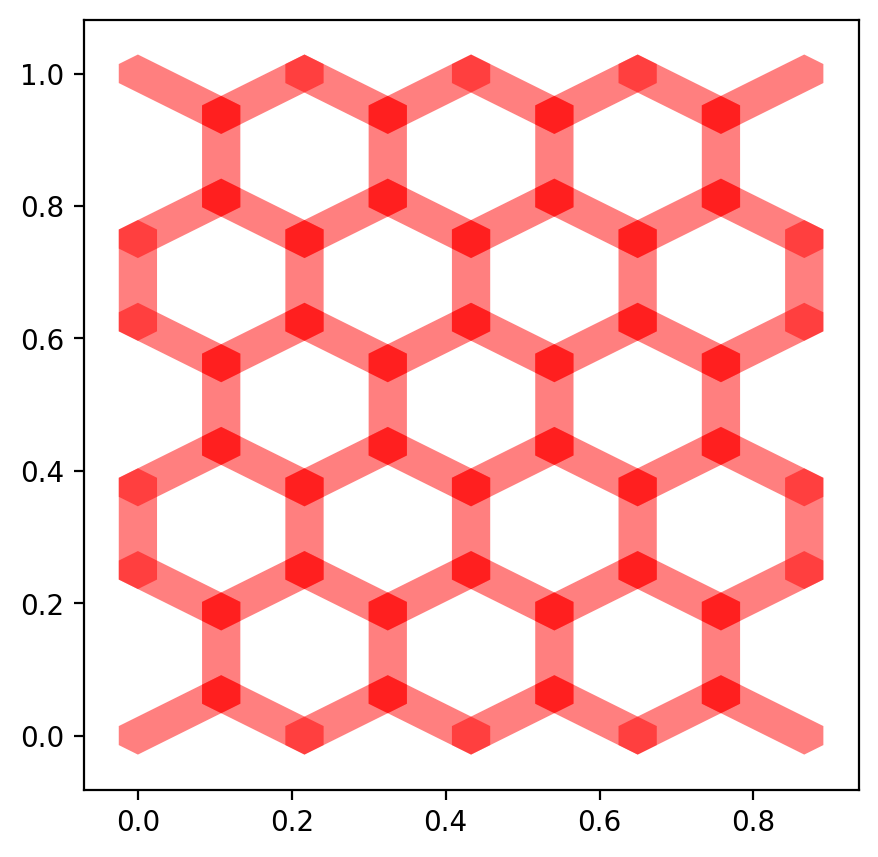

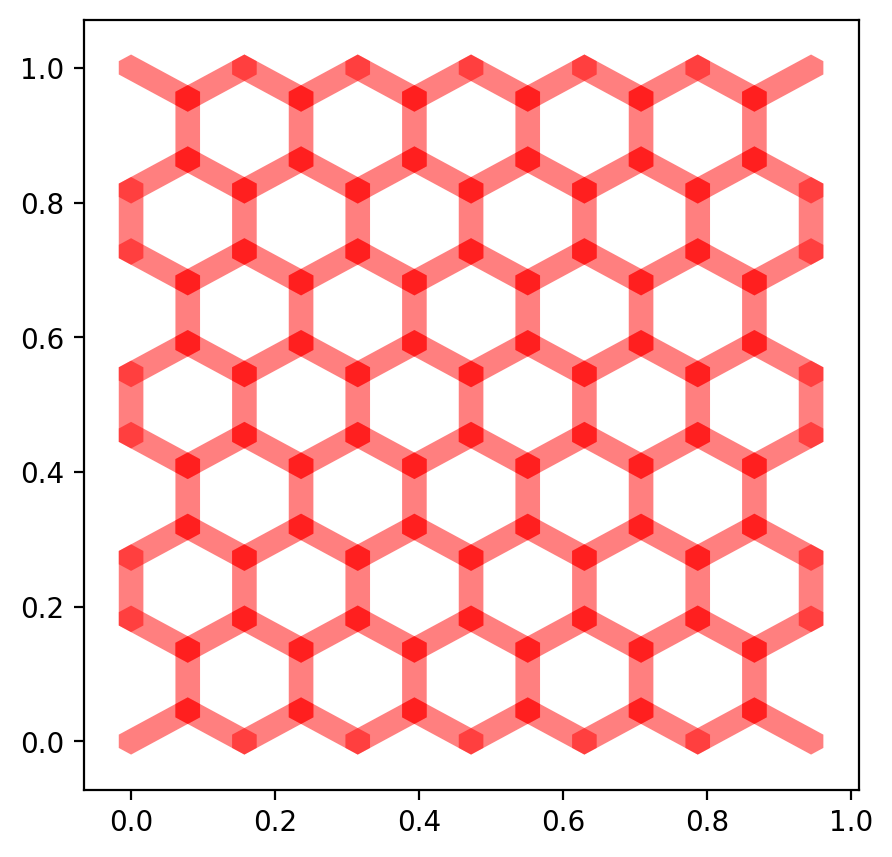

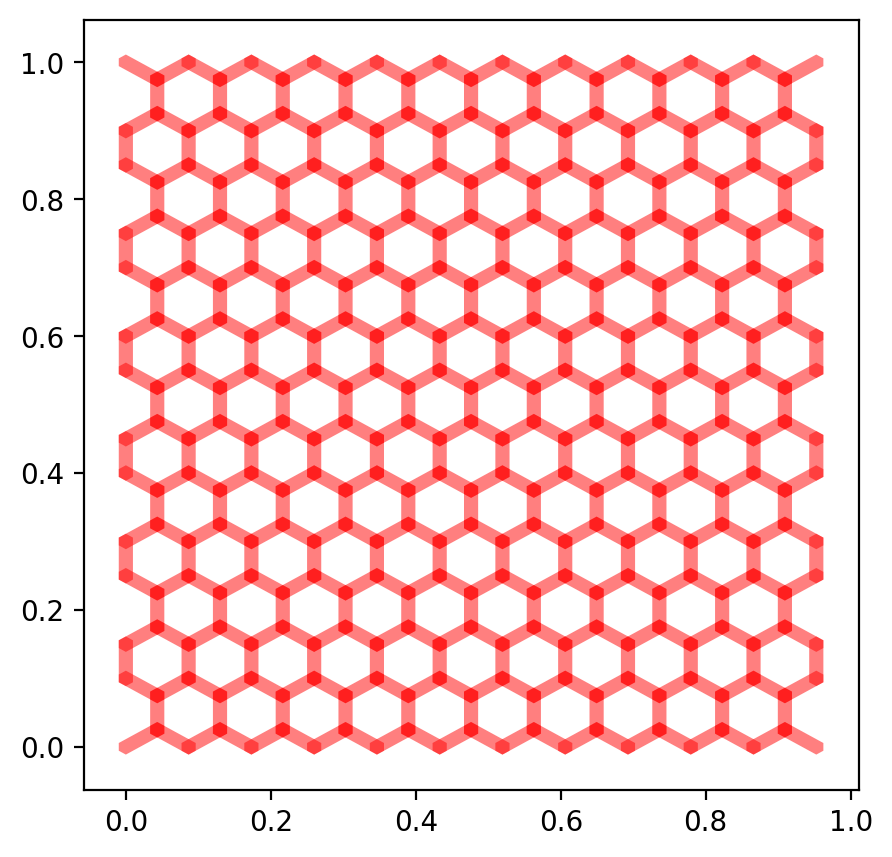

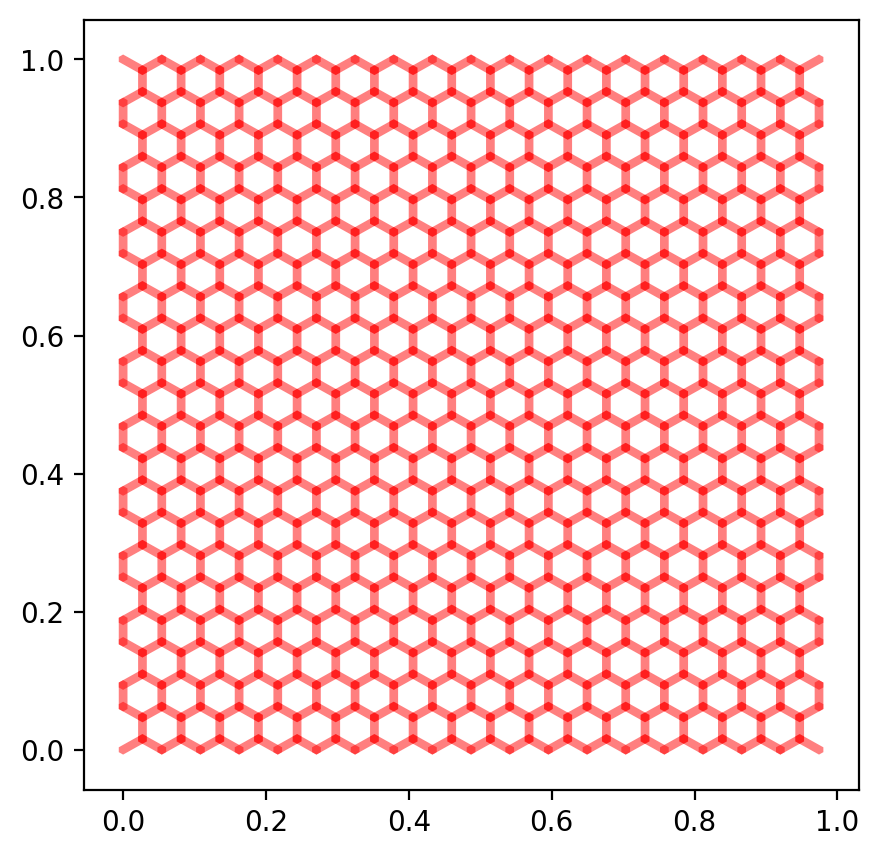

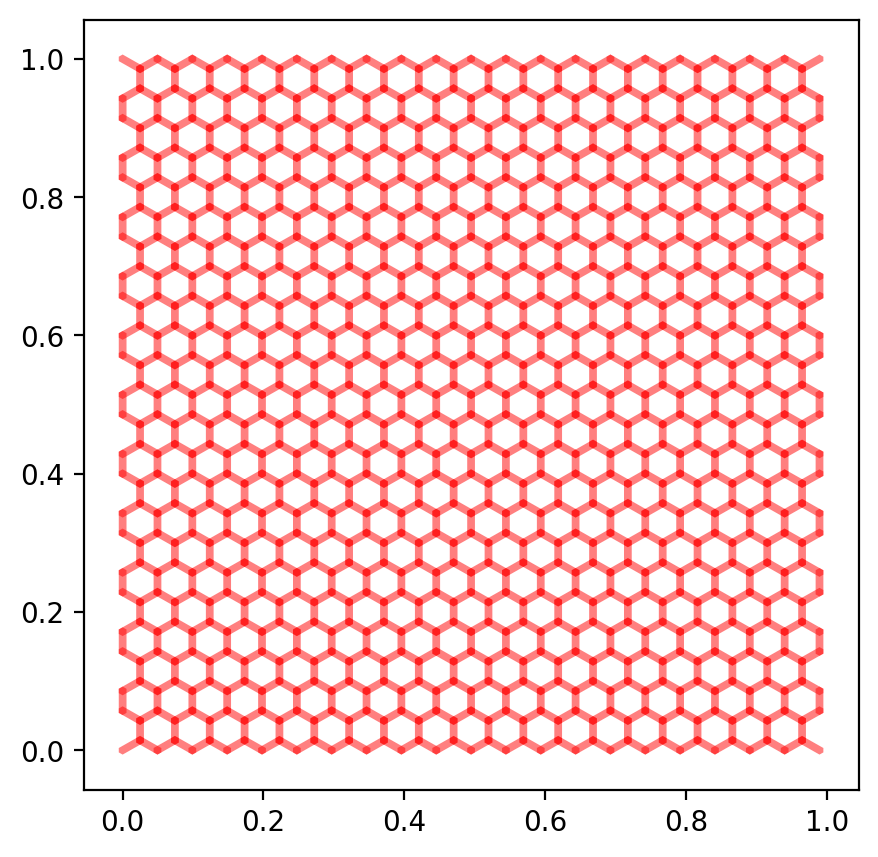

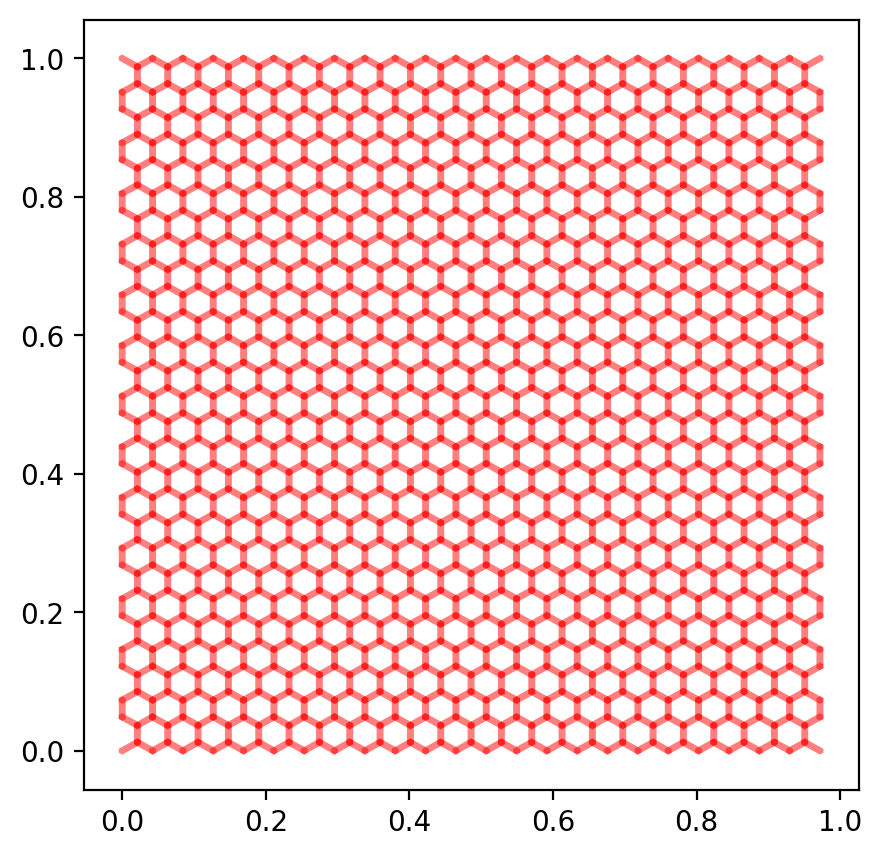

In [ ]:
def generate_hex(hls,edges, keep_frac, thickness):

    edges_tuple = [tuple(e) for e in edges]
    #boundary edges where x = 0 or x = 1 or y = 0 or y = 1
    boundary_edges = []
    for e in edges_tuple:
        if hls[e[0]][0] == 0 or hls[e[0]][0] == 1 or hls[e[0]][1] == 0 or hls[e[0]][1] == 1 or hls[e[1]][0] == 0 or hls[e[1]][0] == 1 or hls[e[1]][1] == 0 or hls[e[1]][1] == 1:
            boundary_edges.append(e)

    #random_edges
    random_edges = []

    for e in edges_tuple:
        if e in boundary_edges:
            random_edges.append(e)
        elif random.random() < keep_frac:
            random_edges.append(e)
    #random_edges = [e for e in edges_tuple if random.random() < 0.99]

    lcc_edges = filter_largest_component_from_edges(random_edges)

    structure, area = edge_thickness(lcc_edges, hls, thickness = thickness)

    return structure, area



avg_thickness = 0.0096  #[0.007, 0.0085, 0.0115, 0.0145, 0.0175]:

adjustment = { 3:-0.0012, 5:-0.0006, 10:0.00,
             17:0.00005, 19:0.00003, 22:0.00007}

for u, p in unit_cells.items():
    hls,edges = p['pts'], p['edges']
    avg_thickness = p['avg_thickness'] + adjustment[u]
    structure, area = generate_hex(hls,  edges, keep_frac=1.0, thickness= avg_thickness )

    new_area = area - len(edges)*np.sqrt(3)*(avg_thickness**2)+len(hls)*np.sqrt(3)*(avg_thickness**2)/2


    thickness_string = str(round(avg_thickness,3)).replace(r'.', r'p')
    file_name = 'sample_hex_'+str(int(u+2))+'_l'+str(thickness_string)+'_fixed_d'+str(int(new_area*100)) #+'_' + str(removal) +'pct_' + str(replicate)
    print(file_name, new_area, avg_thickness)

    
    #f_x_max = hls[:,0].max()
    #f_y_max = hls[:,1].max()
    #f_x_min = hls[:,0].min()
    #f_y_min = hls[:,1].min()

    structure_list = []
    for k,v in structure.items():
        for vv in v:
            structure_list.append(vv)

    structure_list = np.array(structure_list)


    f_x_max = structure_list[:,0].max()
    f_y_max = structure_list[:,1].max()

    f_x_min = structure_list[:,0].min()
    f_y_min = structure_list[:,1].min()


    path = r"./"

    save_stl(structure, out_plane_thickness = .25, name = path+file_name+'.stl', f_x_max=f_x_max, f_y_max = 1, f_x_min=f_x_min, f_y_min = 0, frame_thickness = 0.05)

    #save the polygon_dict to a pickle file
    with open(path+'input_'+file_name + '.pkl', 'wb') as f:
        pickle.dump(structure, f, protocol=2)

# Square Lattice

In [15]:
#define a square lattice
def unit_square_lattice(n):
    points = []
    a = 1/n
    for i in range(n+1):
        for j in range(n+1):
            points.append([i*a,j*a])

    return np.array(points)


number_of_squares = 20
sl_points = unit_square_lattice(n = number_of_squares)

sl_edges = get_edges(points = sl_points, r = 1/number_of_squares)

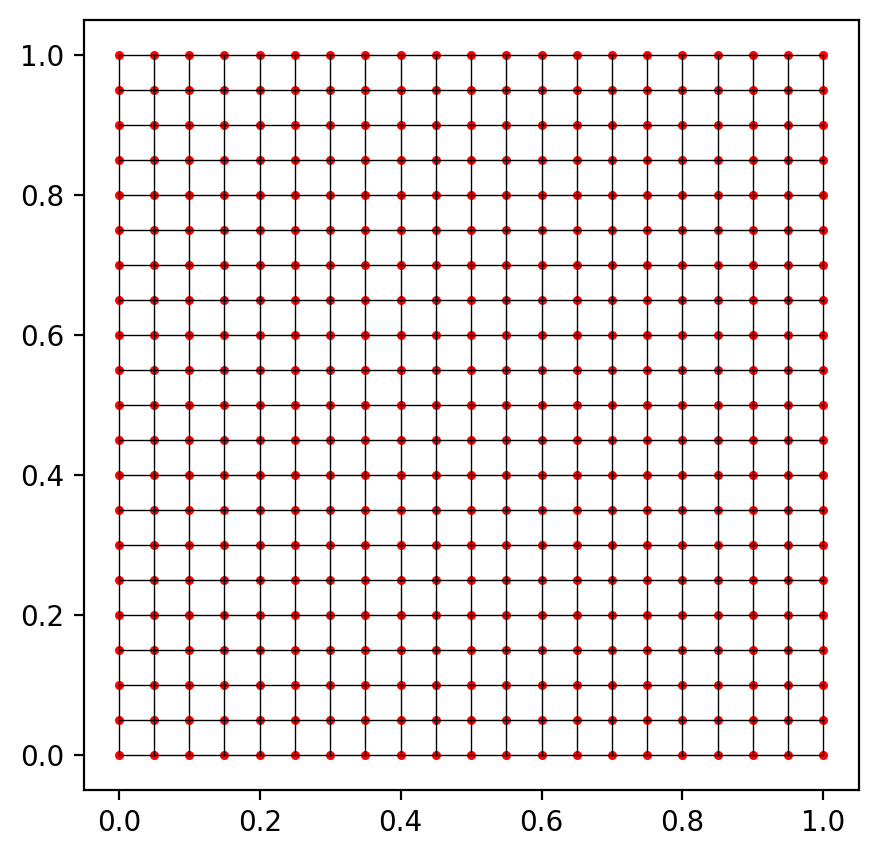

In [16]:
fig,ax1 = plt.subplots(figsize=(5,5))

plt.scatter(sl_points[:,0], sl_points[:,1], c = 'red',s= 5);

for e in sl_edges:
    plt.plot([sl_points[e[0]][0], sl_points[e[1]][0]], [sl_points[e[0]][1], sl_points[e[1]][1]], c = 'black', linewidth = 0.5)

3
16 0.05562500000000001
5
36 0.03708333333333333
7
64 0.0278125
9
100 0.022250000000000002
11
144 0.018541666666666665
13
196 0.015892857142857143
15
256 0.01390625
17
324 0.012361111111111111
19
400 0.011125000000000001
21
484 0.010113636363636365
23
576 0.009270833333333334
25
676 0.008557692307692308


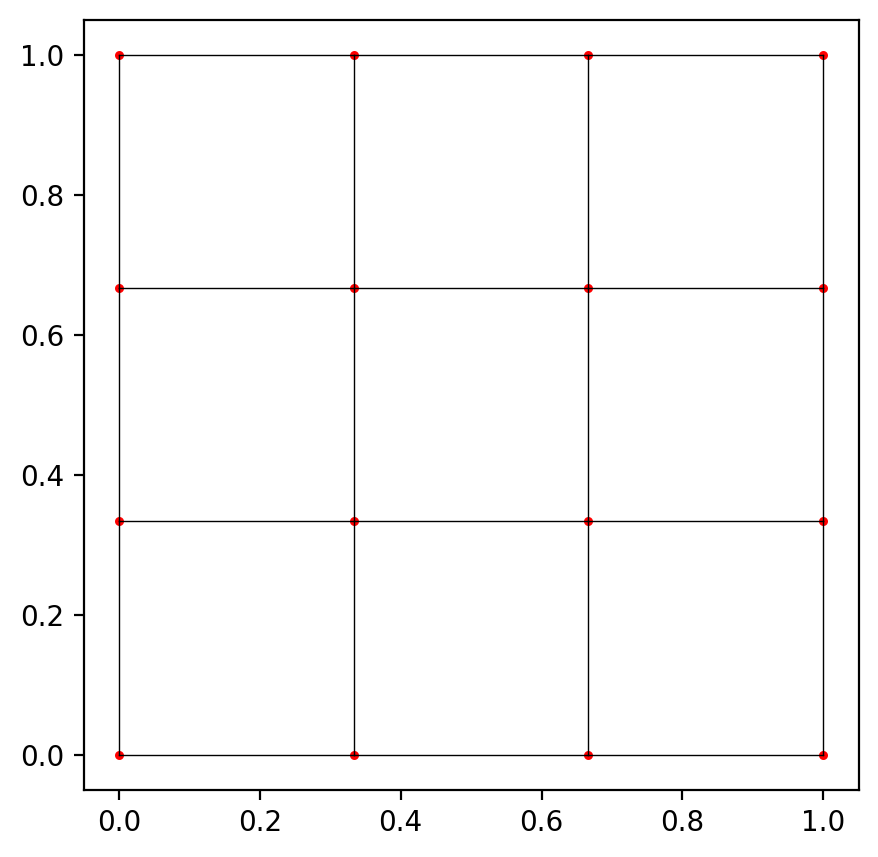

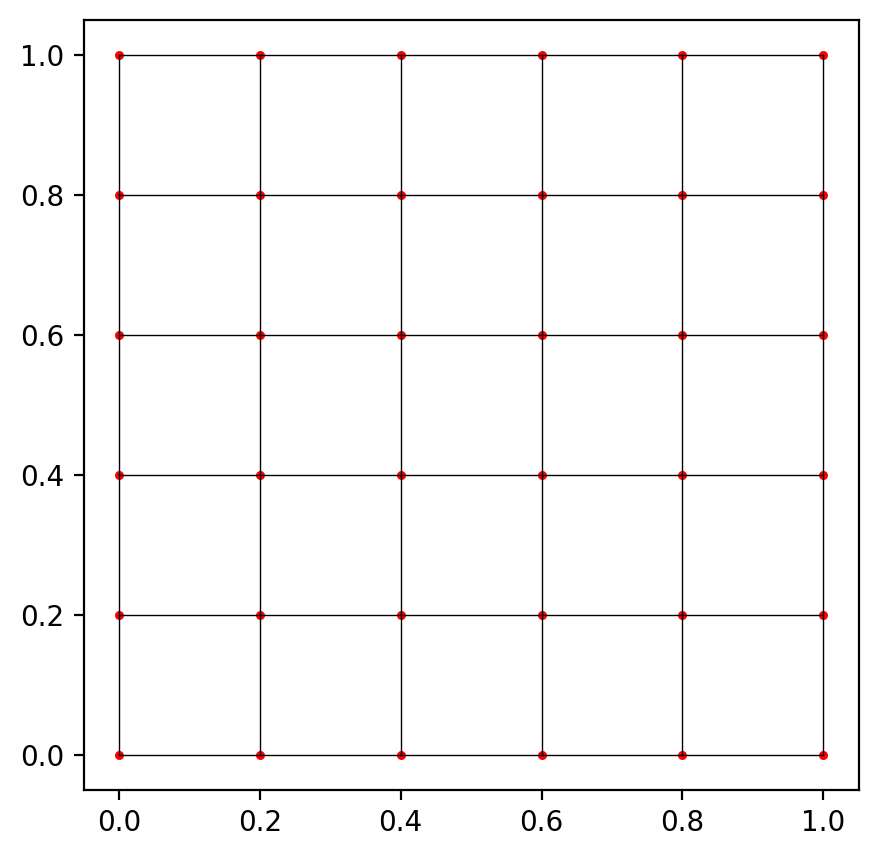

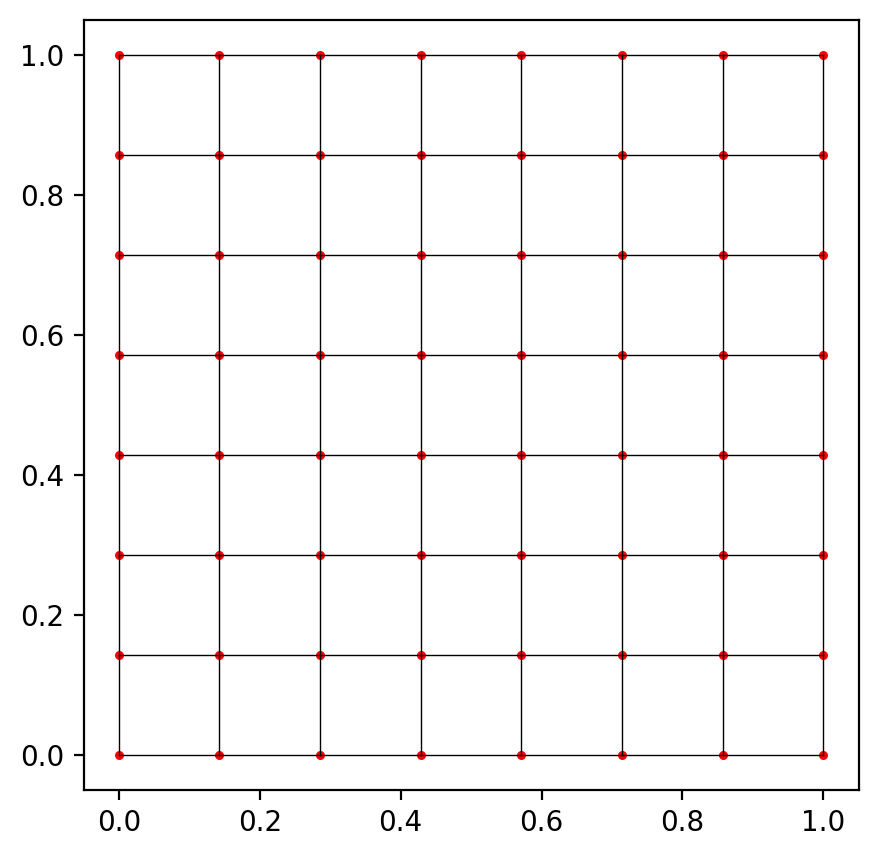

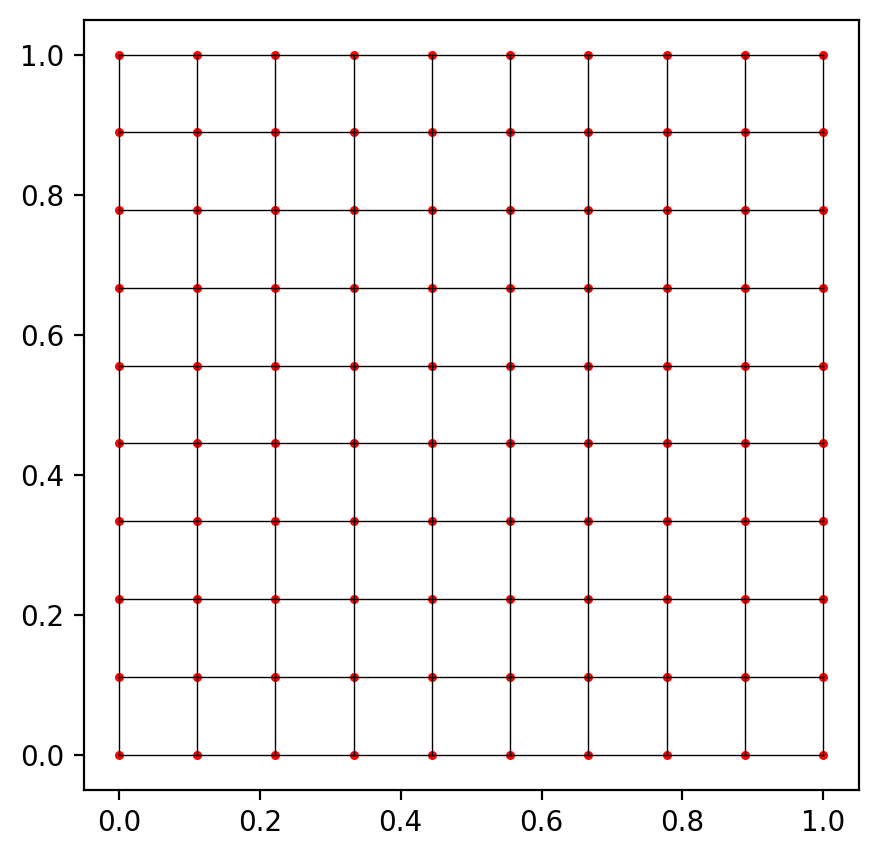

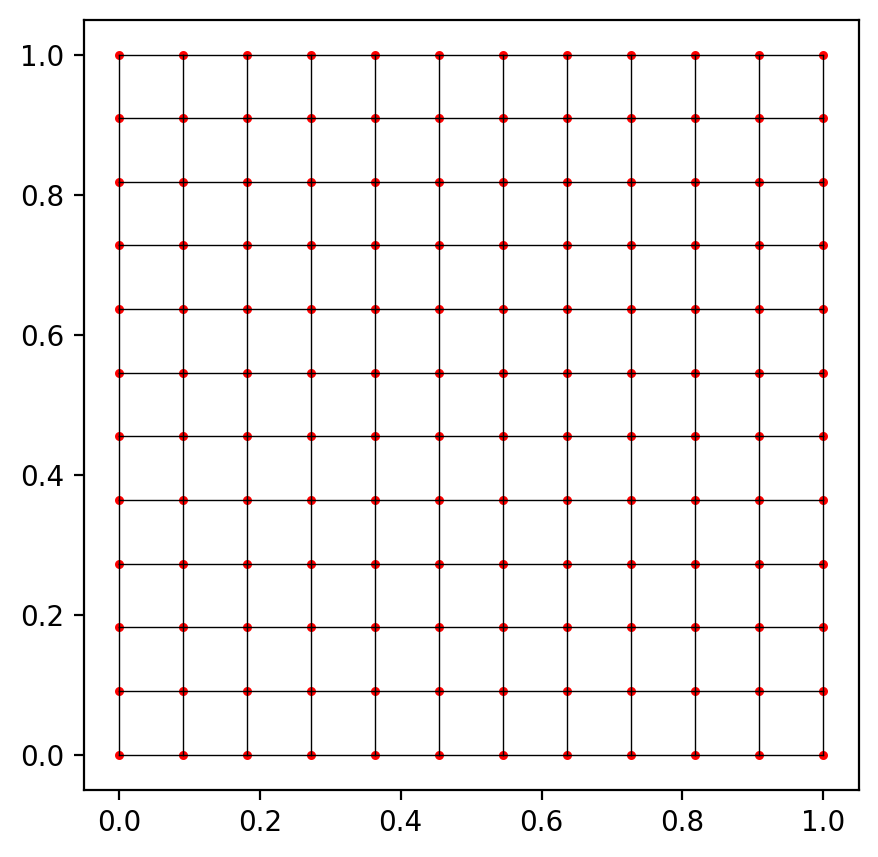

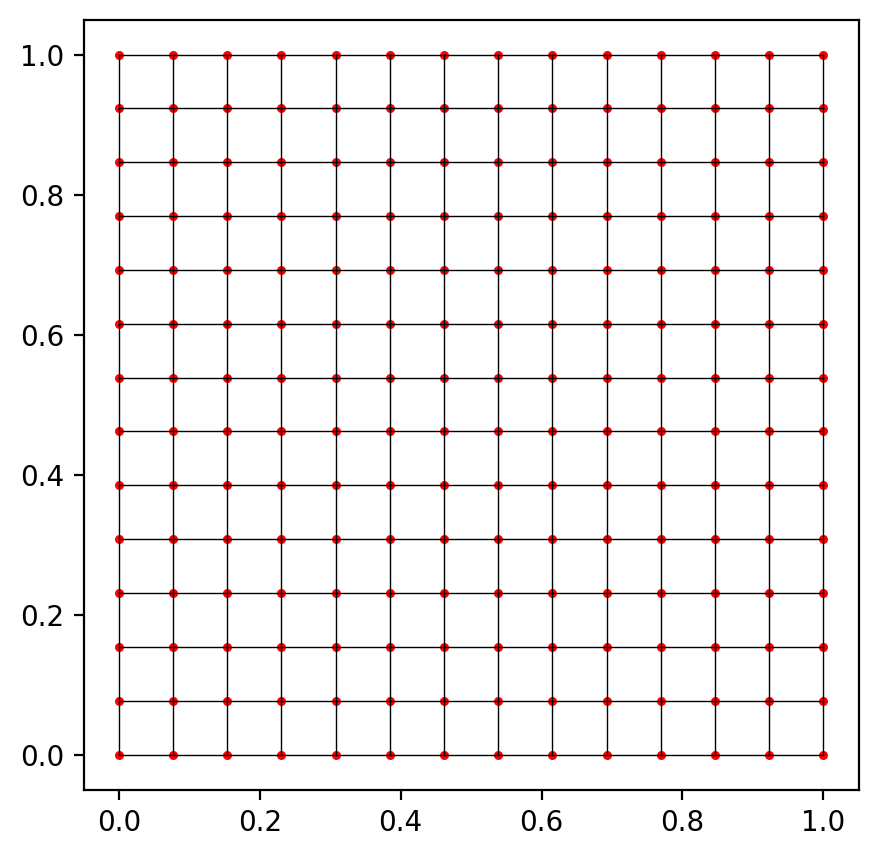

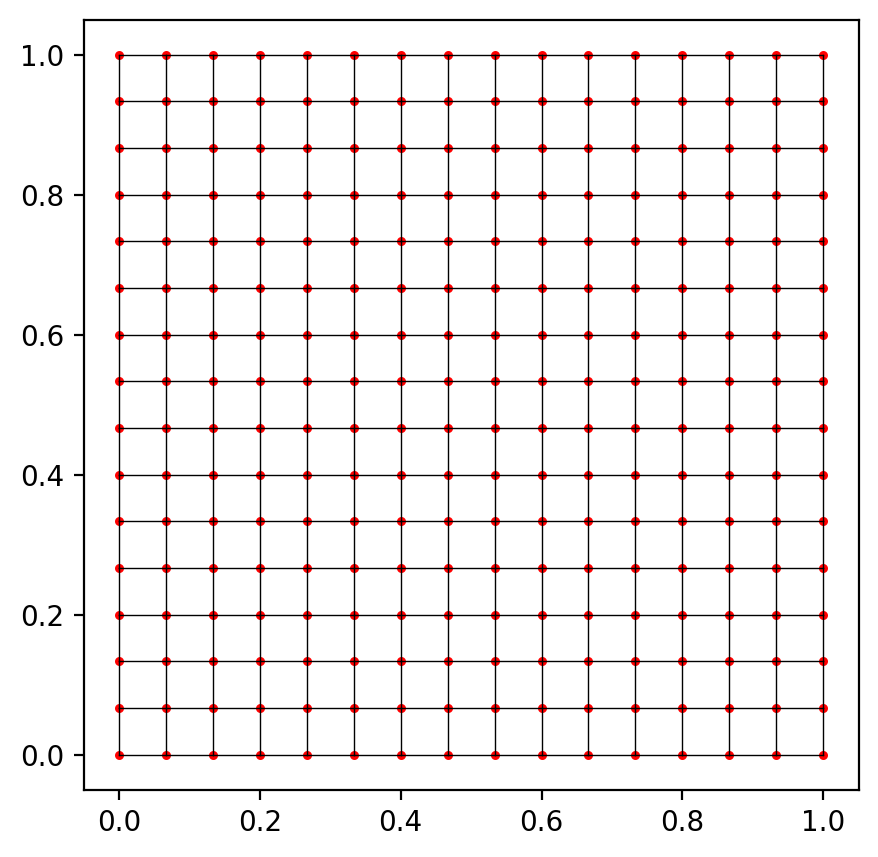

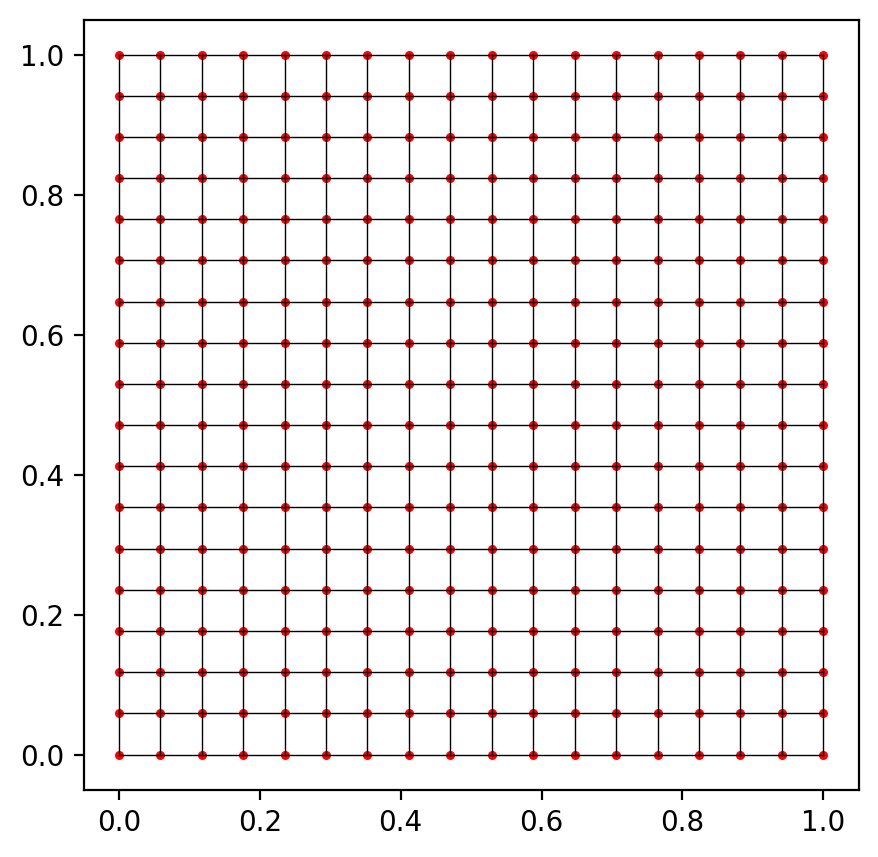

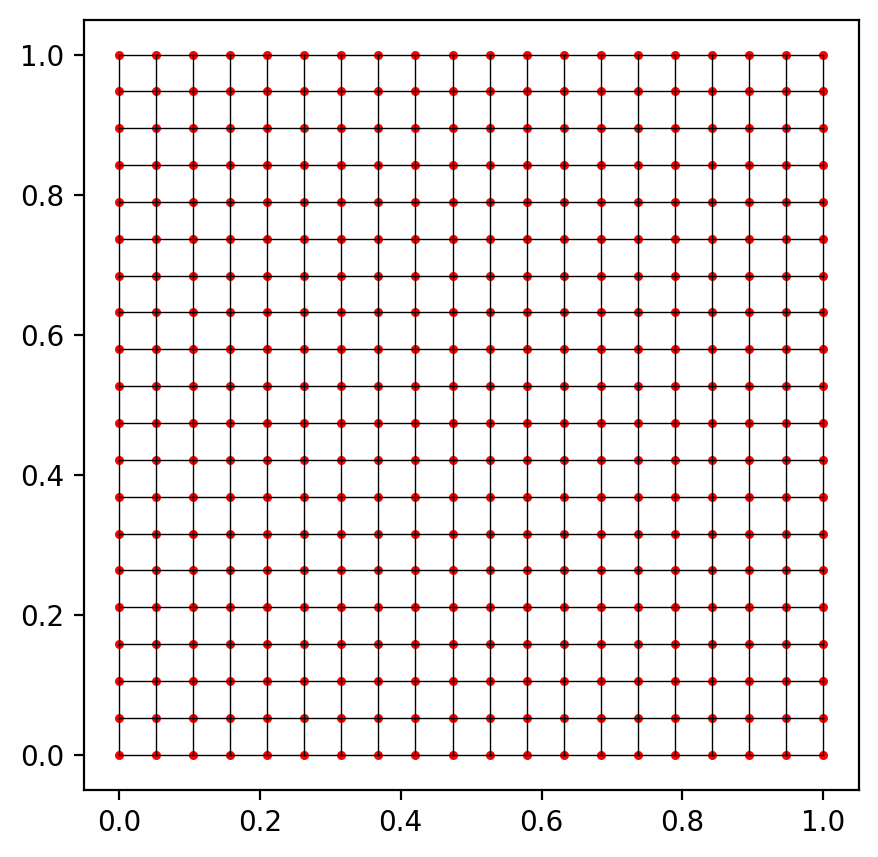

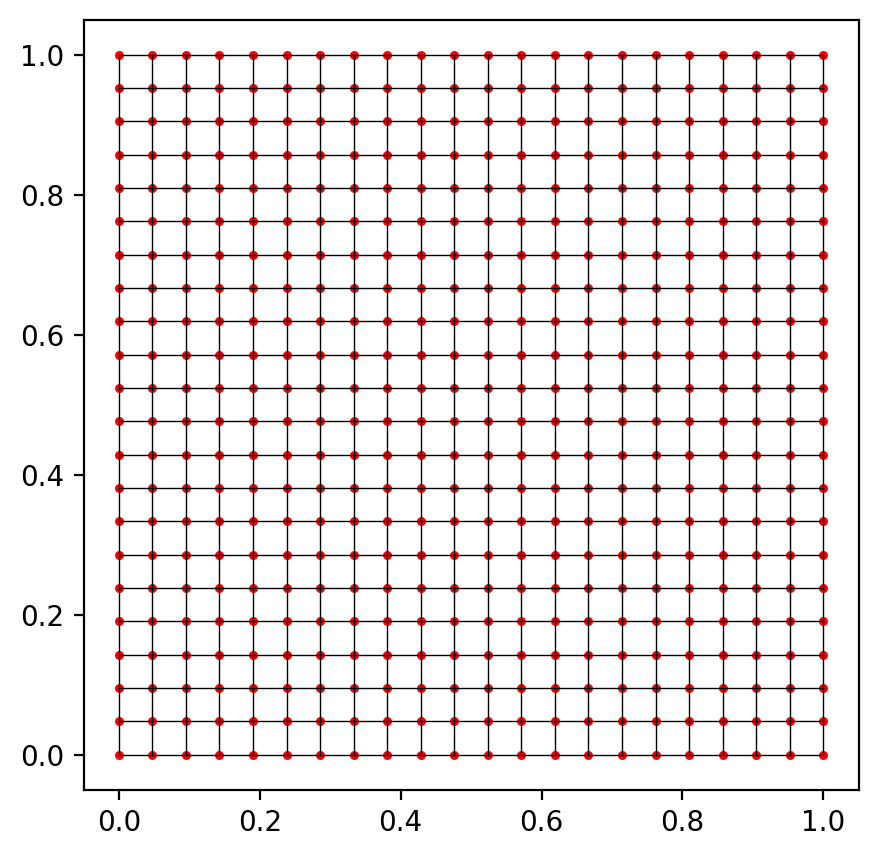

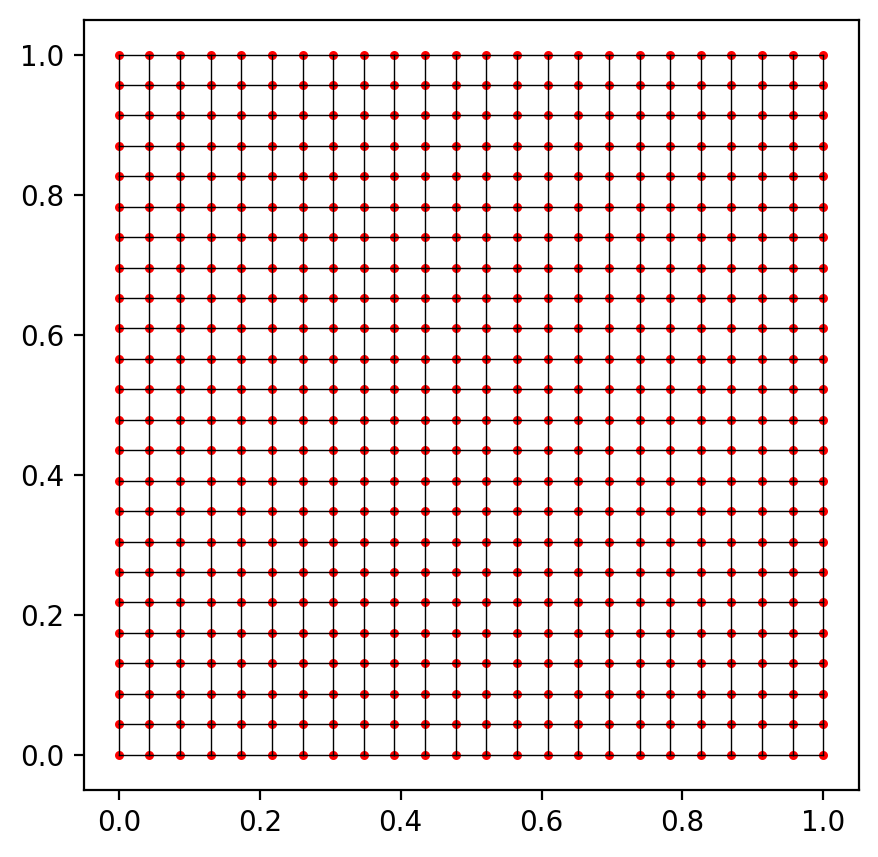

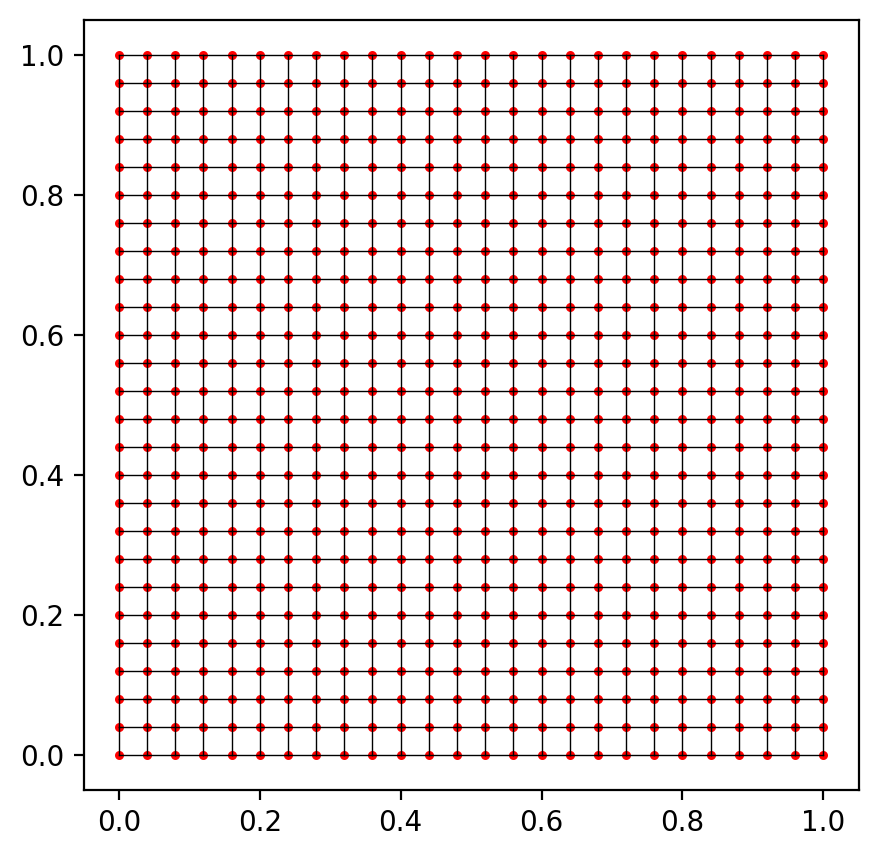

In [121]:
# different unit cells
unit_cells_sq = { 3:{'pts':None, 'edges':None}, 5:{'pts':None, 'edges':None}, 7:{'pts':None, 'edges':None},
                 9:{'pts':None, 'edges':None}, 11:{'pts':None, 'edges':None}, 13:{'pts':None, 'edges':None},
                    15:{'pts':None, 'edges':None}, 17:{'pts':None, 'edges':None}, 19:{'pts':None, 'edges':None},
                    21:{'pts':None, 'edges':None}, 23:{'pts':None, 'edges':None}, 25:{'pts':None, 'edges':None}}



for un in unit_cells_sq:
    print(un)
    sl_points = unit_square_lattice(n = un)
    sl_edges = get_edges(points = sl_points, r = 1/un)
    unit_cells_sq[un]['pts'] = sl_points
    unit_cells_sq[un]['edges'] = sl_edges

    fig,ax1 = plt.subplots(figsize=(5,5))

    avg_thickness = 0.445 / (len(sl_edges))/ (1/un)
    print(len(sl_points), avg_thickness)
    unit_cells_sq[un]['avg_thickness'] = avg_thickness

    plt.scatter(sl_points[:,0], sl_points[:,1], c = 'red',s= 5);

    for e in sl_edges:
        plt.plot([sl_points[e[0]][0], sl_points[e[1]][0]], [sl_points[e[0]][1], sl_points[e[1]][1]], c = 'black', linewidth = 0.5)
    

In [17]:
def square_lattice_edge_thickness(edges, pts, thickness):
    polygon_dict = {}
    area = []

    fig,ax1 = plt.subplots(figsize=(5,5))

    for en, e in enumerate(edges):

        x1 = pts[e[0]][0]
        y1= pts[e[0]][1]

        x2 = pts[e[1]][0]
        y2 = pts[e[1]][1]

        #createa Point object fro x1,y1 and x2,y2

        line = LineString([(x1,y1),(x2,y2)])
        line_1 = extend_line(line, thickness/2)

        #get a points t distance from line end points on the line
        p1 = Point(line_1.coords[0])
        p2 = Point(line_1.coords[-1])

        #print(p1, p2)

        #get normal vector to the line from p1 
        n = np.array([y2-y1, x1-x2])
        n = n/np.linalg.norm(n)
        p1_up = np.array(p1.coords[0]) + thickness*n/2
        p1_down = np.array(p1.coords[0]) - thickness*n/2
        
        p2_up = np.array(p2.coords[0]) + thickness*n/2
        p2_down = np.array(p2.coords[0]) - thickness*n/2

        #define a polygon with p1, p1_up, p2_up, p2, p2_down, p1_down
        polygon = Polygon([ p1_up, p2_up, p2_down, p1_down])
        
        #order polygon vertices to generate a convex polygon
        polygon = Polygon(polygon.exterior.coords[:])

        
        if polygon.is_valid:
            convex_polygon = polygon.convex_hull
        
        #get the polygon coordinates
        polygon_dict[en] = convex_polygon.exterior.coords[:]
        
        area += [convex_polygon.area]
        #plot the polygon
        plt.fill(*convex_polygon.exterior.xy, c = 'red', linewidth = .01,alpha = 0.5)

    return polygon_dict, np.sum(area)

0.4003683599999993


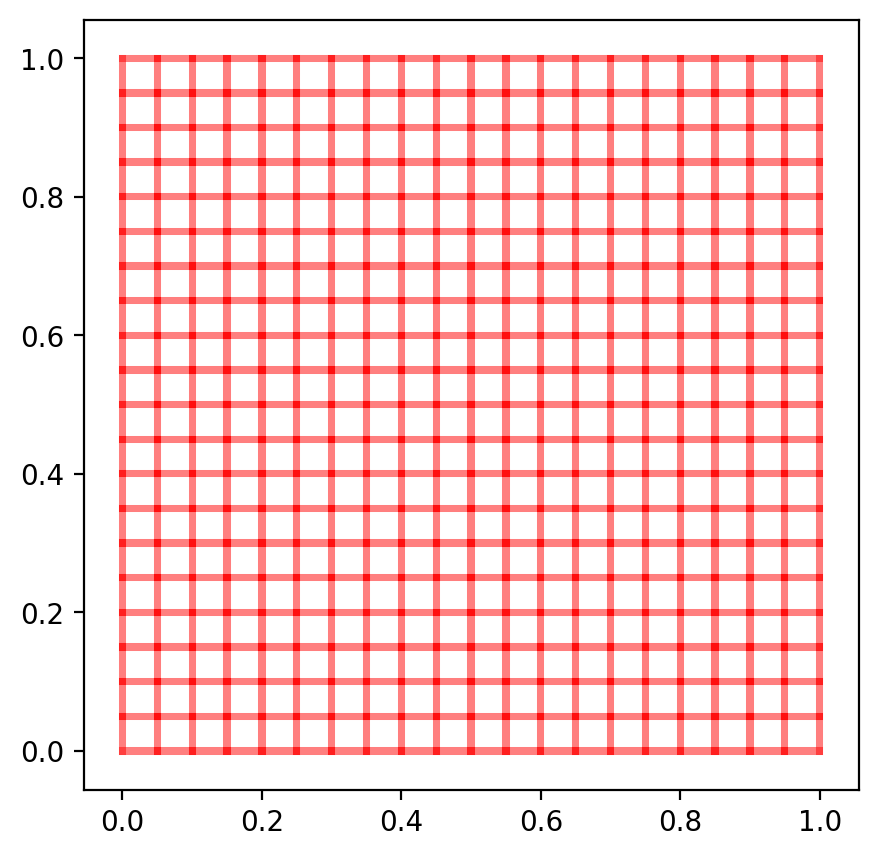

In [18]:
#[0.005:20, 0.0078:30, 0.0106:40,  0.0137:50, 0.01705:60, 0.0208:30]
t_ = 0.0106
structure, area = square_lattice_edge_thickness(sl_edges, sl_points, thickness = t_)


new_area = area - len(sl_edges)*2*(t_**2)+len(sl_points)*(t_**2)

print(new_area)

In [20]:
#square
(840, 441)

area - len(sl_edges)*2*(0.01**2)+len(sl_points)*(0.01**2) - -40

40.4156824

In [ ]:
def generate_square(sl_points,  sl_edges, keep_frac, thickness):
    sl_edges_tuple = [tuple(e) for e in sl_edges]
    #boundary edges where x = 0 or x = 1 or y = 0 or y = 1

    sl_boundary_edges = []
    for e in sl_edges_tuple:
        if sl_points[e[0]][0] == 0 or sl_points[e[0]][0] == 1 or sl_points[e[0]][1] == 0 or sl_points[e[0]][1] == 1 or sl_points[e[1]][0] == 0 or sl_points[e[1]][0] == 1 or sl_points[e[1]][1] == 0 or sl_points[e[1]][1] == 1:
            sl_boundary_edges.append(e)

    #random_edges
    sl_random_edges = []
    for e in sl_edges_tuple:
        if e in sl_boundary_edges:
            sl_random_edges.append(e)
        elif random.random() < keep_frac:
            sl_random_edges.append(e)
    #random_edges = [e for e in edges_tuple if random.random() < 0.99]

    sl_lcc_edges = filter_largest_component_from_edges(sl_random_edges)

    structure, area = square_lattice_edge_thickness(sl_lcc_edges, sl_points, thickness = thickness)

    return structure, area


keep_frac = [0.99, 0.95, 0.90, 0.85, 0.80]#[1, 0.99, 0.95, 0.90, 0.85, 0.80]
for replicate in [1, 2]: #[0,1,2]
    for keep in keep_frac: 
        for avg_thickness in [0.005, 0.0078, 0.0106,  0.0137, 0.01705, 0.0208]:#[0.0075, 0.010, 0.013, 0.016, 0.019]:
                structure, area = generate_square(sl_points,  sl_edges, keep, avg_thickness)
                #print(area,keep, avg_thickness, replicate)

                new_area = area - len(sl_edges)*2*(avg_thickness**2)+len(sl_points)*(avg_thickness**2)
                #print(round(new_area,2))

        
                removal = int(100 * (1.0 - keep))
                thickness_string = str(round(avg_thickness,3)).replace(r'.', r'p')
                file_name = 'sample_square_r'+str(int(100-keep*100))+'_l'+str(thickness_string)+'_v'+str(replicate)+'_d'+str(int(new_area*100))
                print(file_name)
                
                path = r"./"
                save_stl(structure, out_plane_thickness = .25, name = path+file_name+'.stl', frame_thickness = None) #avg_thickness)


            #save the polygon_dict to a pickle file
            with open(path+'input_'+file_name + '.pkl', 'wb') as f:
                pickle.dump(structure, f, protocol=2)

sample_square_r0_l0p005_v0_d20
sample_square_r0_l0p008_v0_d30
sample_square_r0_l0p011_v0_d40
sample_square_r0_l0p014_v0_d50
sample_square_r0_l0p017_v0_d60
sample_square_r0_l0p021_v0_d70


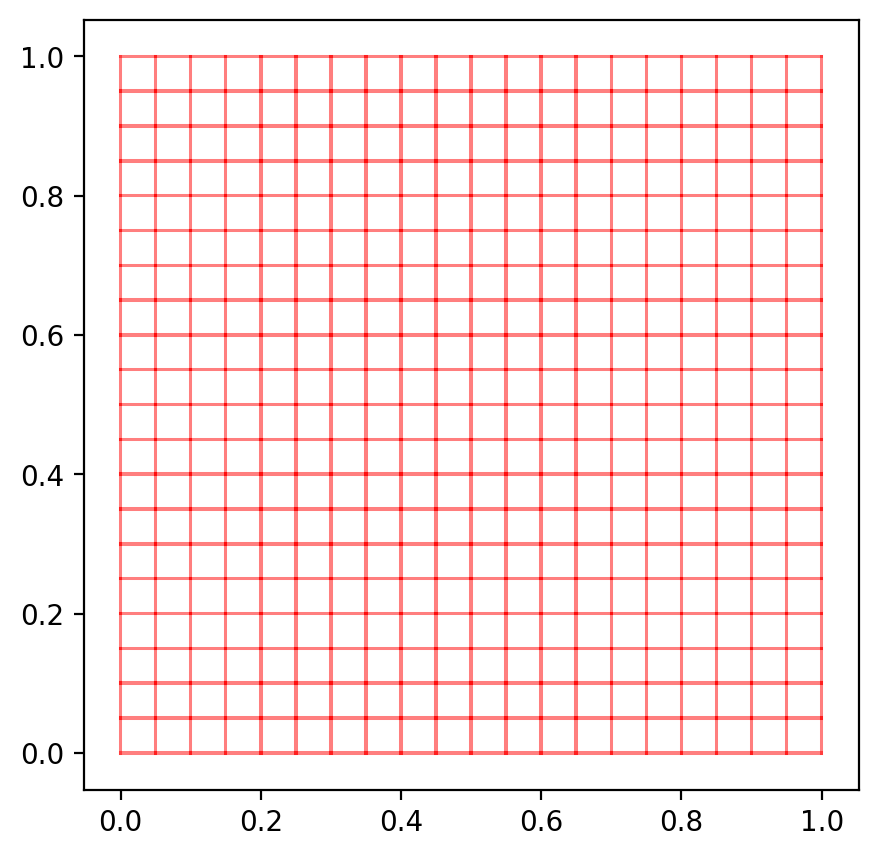

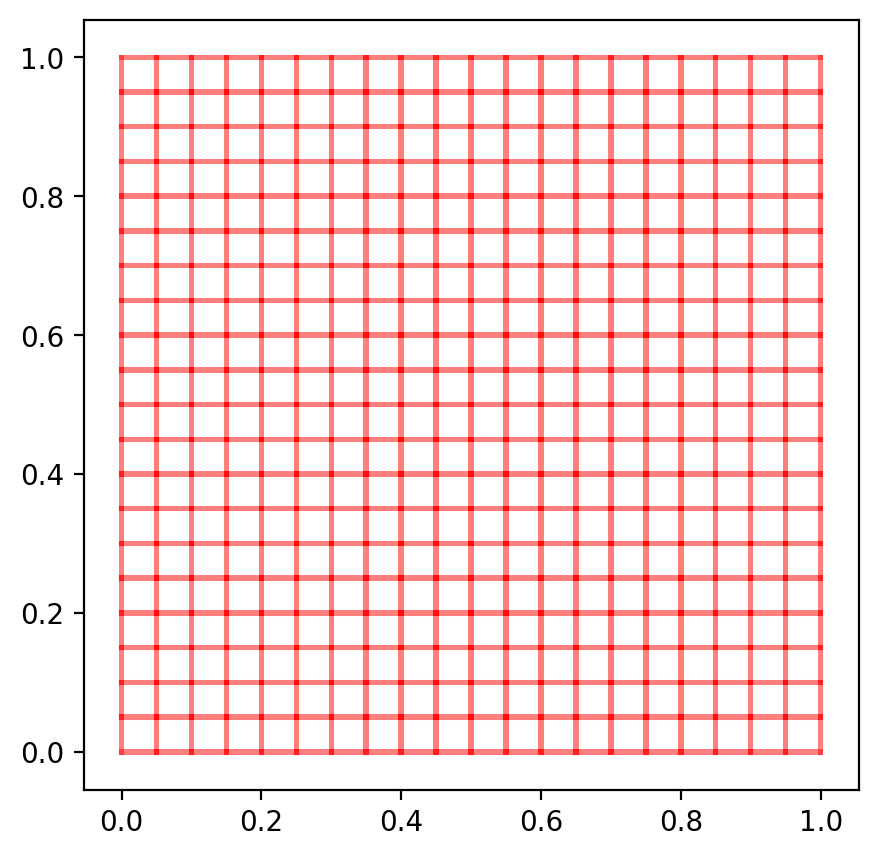

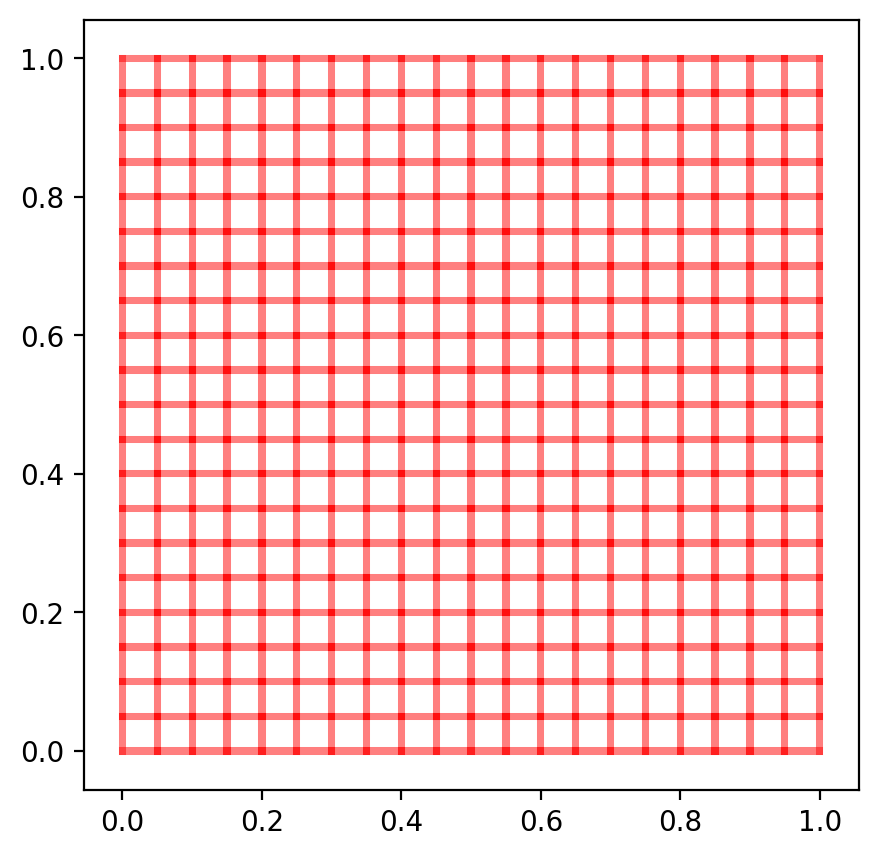

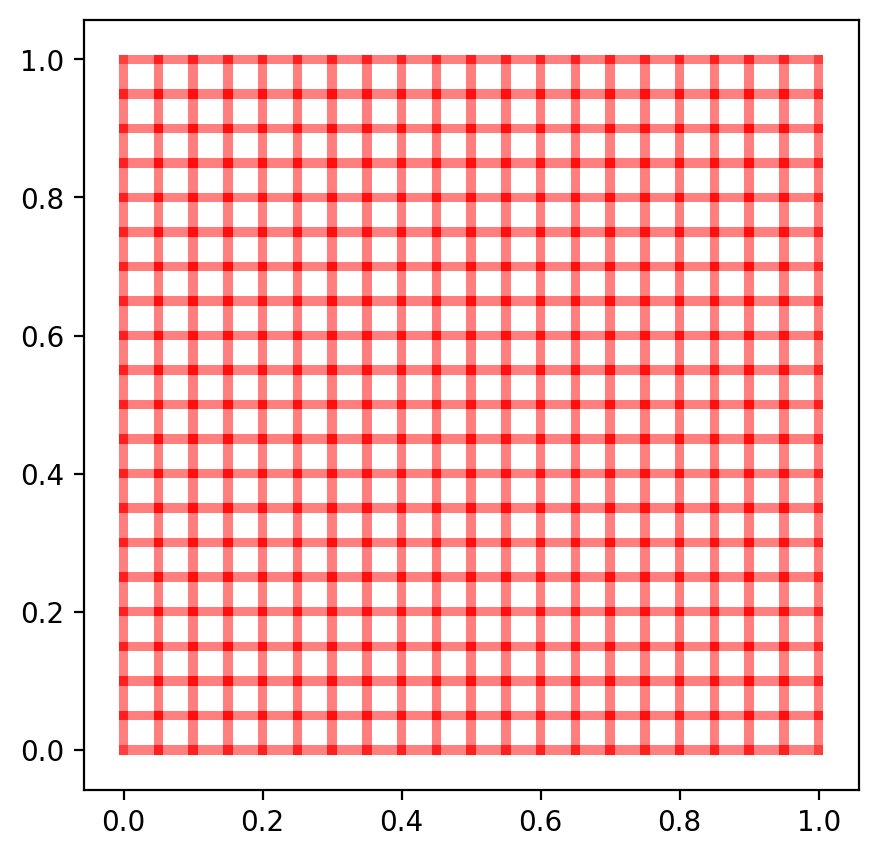

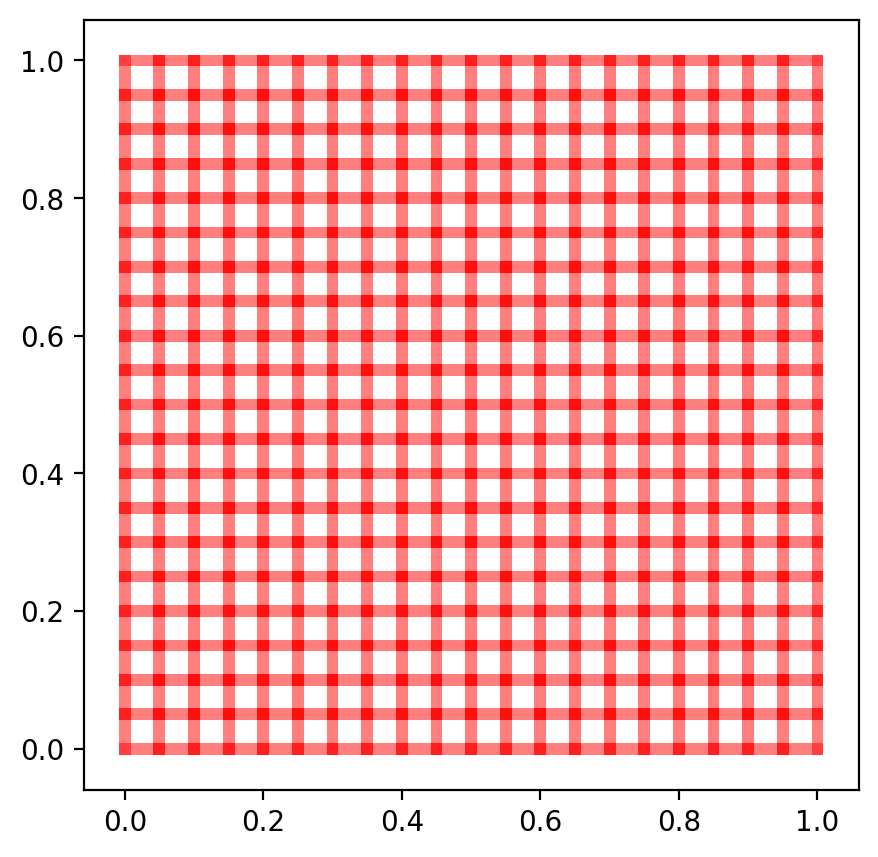

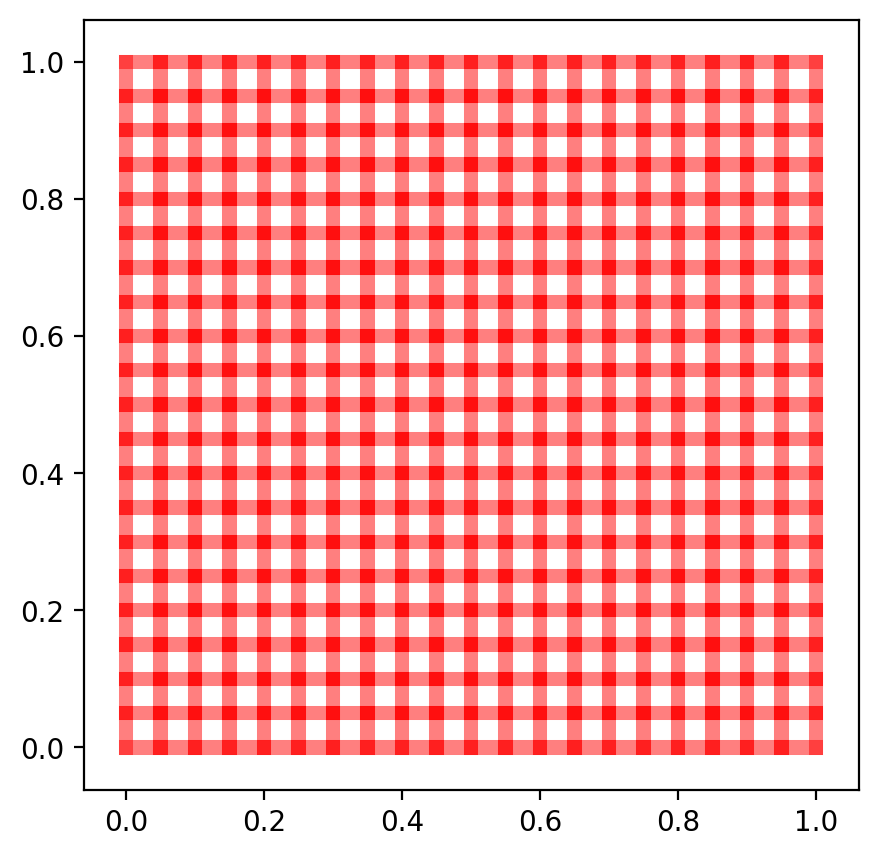

In [ ]:
def generate_square(sl_points,  sl_edges, keep_frac, thickness):
    sl_edges_tuple = [tuple(e) for e in sl_edges]
    #boundary edges where x = 0 or x = 1 or y = 0 or y = 1

    sl_boundary_edges = []
    for e in sl_edges_tuple:
        if sl_points[e[0]][0] == 0 or sl_points[e[0]][0] == 1 or sl_points[e[0]][1] == 0 or sl_points[e[0]][1] == 1 or sl_points[e[1]][0] == 0 or sl_points[e[1]][0] == 1 or sl_points[e[1]][1] == 0 or sl_points[e[1]][1] == 1:
            sl_boundary_edges.append(e)

    #random_edges
    sl_random_edges = []
    for e in sl_edges_tuple:
        if e in sl_boundary_edges:
            sl_random_edges.append(e)
        elif random.random() < keep_frac:
            sl_random_edges.append(e)
    #random_edges = [e for e in edges_tuple if random.random() < 0.99]

    sl_lcc_edges = filter_largest_component_from_edges(sl_random_edges)

    structure, area = square_lattice_edge_thickness(sl_lcc_edges, sl_points, thickness = thickness)

    return structure, area, sl_lcc_edges, sl_points


keep_frac = [1]#[0.99, 0.95, 0.90, 0.85, 0.80]#[1, 0.99, 0.95, 0.90, 0.85, 0.80]
for replicate in [0]: #[0,1,2]
    for keep in keep_frac: 
        for avg_thickness in [0.005, 0.0078, 0.0106,  0.0137, 0.01705, 0.0208]:#[0.0075, 0.010, 0.013, 0.016, 0.019]:
                structure, area, ed, pts = generate_square(sl_points,  sl_edges, keep, avg_thickness)
                #print(area,keep, avg_thickness, replicate)

                new_area = area - len(sl_edges)*2*(avg_thickness**2)+len(sl_points)*(avg_thickness**2)
                #print(round(new_area,2))

        
                removal = int(100 * (1.0 - keep))
                thickness_string = str(round(avg_thickness,3)).replace(r'.', r'p')
                file_name = 'sample_square_r'+str(int(100-keep*100))+'_l'+str(thickness_string)+'_v'+str(replicate)+'_d'+str(int(new_area*100))
                print(file_name)
                
                path = r"./"
                #save_stl(structure, out_plane_thickness = .25, name = path+file_name+'.stl', frame_thickness = None) #avg_thickness)

                output = {
                    'points': pts,
                    'edges': ed, 
                    'structure': structure,
                    'thickness': avg_thickness,
                }

                #save the polygon_dict to a pickle file
                with open(path+'input_'+file_name + '.pkl', 'wb') as f:
                    pickle.dump(output, f, protocol=2) 
                    



In [ ]:
def generate_square(sl_points,  sl_edges, keep_frac, thickness):
    sl_edges_tuple = [tuple(e) for e in sl_edges]
    #boundary edges where x = 0 or x = 1 or y = 0 or y = 1

    sl_boundary_edges = []
    for e in sl_edges_tuple:
        if sl_points[e[0]][0] == 0 or sl_points[e[0]][0] == 1 or sl_points[e[0]][1] == 0 or sl_points[e[0]][1] == 1 or sl_points[e[1]][0] == 0 or sl_points[e[1]][0] == 1 or sl_points[e[1]][1] == 0 or sl_points[e[1]][1] == 1:
            sl_boundary_edges.append(e)

    #random_edges
    sl_random_edges = []
    for e in sl_edges_tuple:
        if e in sl_boundary_edges:
            sl_random_edges.append(e)
        elif random.random() < keep_frac:
            sl_random_edges.append(e)
    #random_edges = [e for e in edges_tuple if random.random() < 0.99]

    sl_lcc_edges = filter_largest_component_from_edges(sl_random_edges)

    structure, area = square_lattice_edge_thickness(sl_lcc_edges, sl_points, thickness = thickness)

    return structure, area


keep_frac = [1]#0.99]#0.95, 0.90, 0.85, 0.80]
for replicate in [0]:#, 1, 2]:
    for keep in keep_frac: 
        for avg_thickness in [0.005, 0.0078, 0.0106,  0.0137, 0.01705, 0.0208]:#[0.0075, 0.010, 0.013, 0.016, 0.019]:
            structure, area = generate_square(sl_points,  sl_edges, keep, avg_thickness)
            #print(area,keep, avg_thickness, replicate)


            new_area = area - len(sl_edges)*2*(avg_thickness**2)+len(sl_points)*(avg_thickness**2)
            print(round(new_area,2))

            removal = int(100 * (1.0 - keep))
            thickness_string = str(avg_thickness).replace(r'.', r'p')
            file_name = 'square_21_th_'+str(thickness_string)+'_area_'+ str(round(new_area,2)).replace('.','p') #'_' + str(removal) +'pct_' + str(replicate)

            print(file_name)

            path = r"./"
            
            structure_list = []
            for k,v in structure.items():
                for vv in v:
                    structure_list.append(vv)

            structure_list = np.array(structure_list)


            f_x = structure_list[:,0].max()
            f_y = structure_list[:,1].max()

            save_stl(structure, out_plane_thickness = .25, name = path+file_name+'_print_fixed'+'.stl', f_x=f_x, f_y=f_y , frame_thickness = None) #avg_thickness)


            #save the structure to a pickle file
            #t = avg_thickness       
            #bottom = [(0.,float(0.-t)), (1.,float(0.-t)), (1.,0.), (0.,0.),(0.,float(0.-t))]
            #top = [(0.,1.), (1.,1.), (1.,float(1.+t)), (0.,float(1.+t)),(0.,1.)]
            #right = [(1.,float(0.-t)), (1.,float(1.+t)), (float(1.+t),float(1.+t)), (float(1.+t),float(0.-t)),(1.,float(0.-t))]
            #left = [(0.,float(0.-t)), (0.,float(1.+t)), (float(0.-t),float(1.+t)), (float(0.-t),float(0.-t)),(0.,float(0.-t))]


            #add the bottom and top line where the order is the max number of the key + 1 and max number of the key + 2
            #structure[max(structure.keys())+1] = bottom
            #structure[max(structure.keys())+1] = top
            #structure[max(structure.keys())+1] = right
            #structure[max(structure.keys())+1] = left

            #save the polygon_dict to a pickle file
            #with open(path+'input_'+file_name + '.pkl', 'wb') as f:
            #    pickle.dump(structure, f, protocol=2)


0.4003
square_3_th_0p053_fixed_d0p4
0.4007
square_5_th_0p036_fixed_d0p4
0.4005
square_7_th_0p027_fixed_d0p4
0.4005
square_9_th_0p022_fixed_d0p4
0.4008
square_11_th_0p018_fixed_d0p4
0.4003
square_13_th_0p016_fixed_d0p4
0.4004
square_15_th_0p014_fixed_d0p4
0.4004
square_17_th_0p012_fixed_d0p4
0.4004
square_19_th_0p011_fixed_d0p4
0.4003
square_21_th_0p01_fixed_d0p4
0.4004
square_23_th_0p009_fixed_d0p4
0.4005
square_25_th_0p009_fixed_d0p4


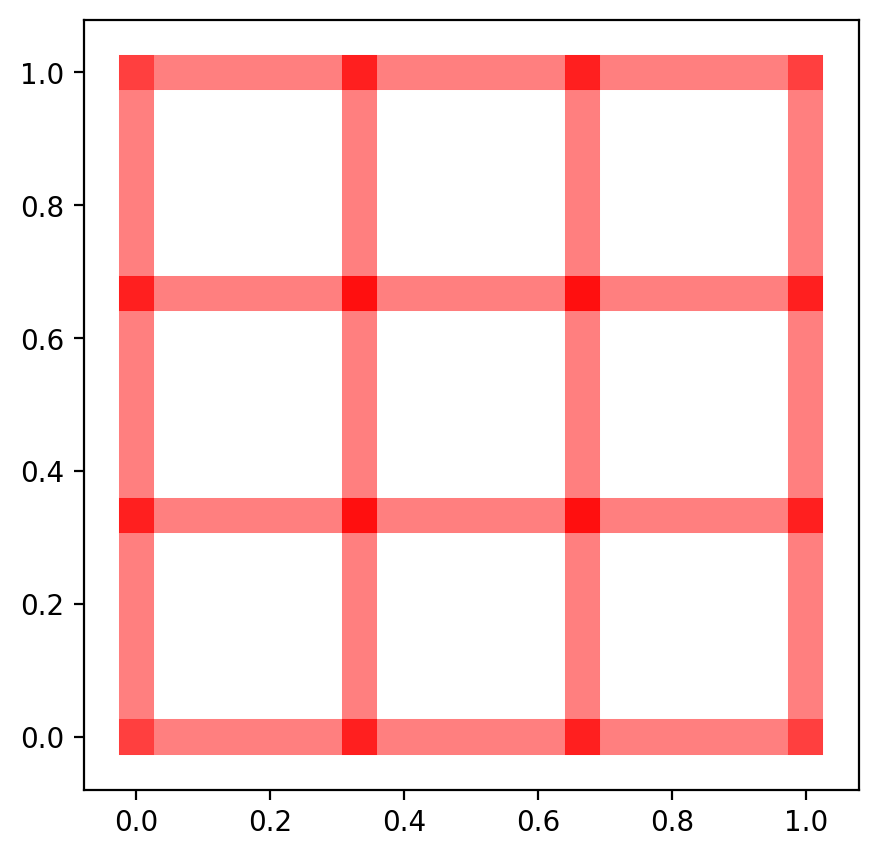

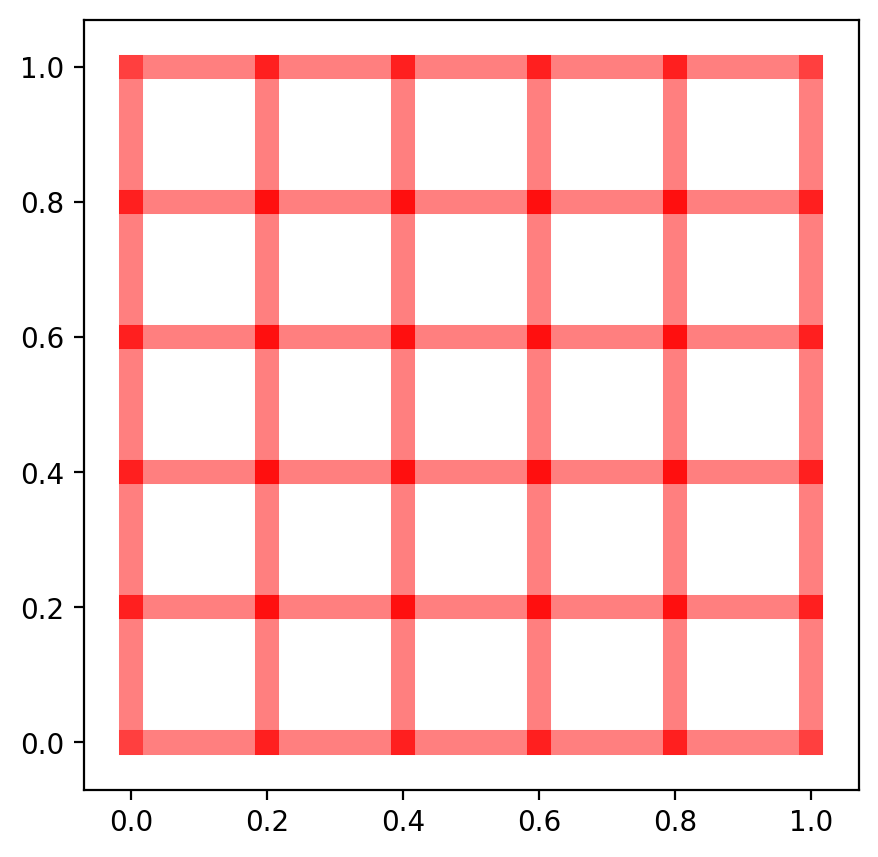

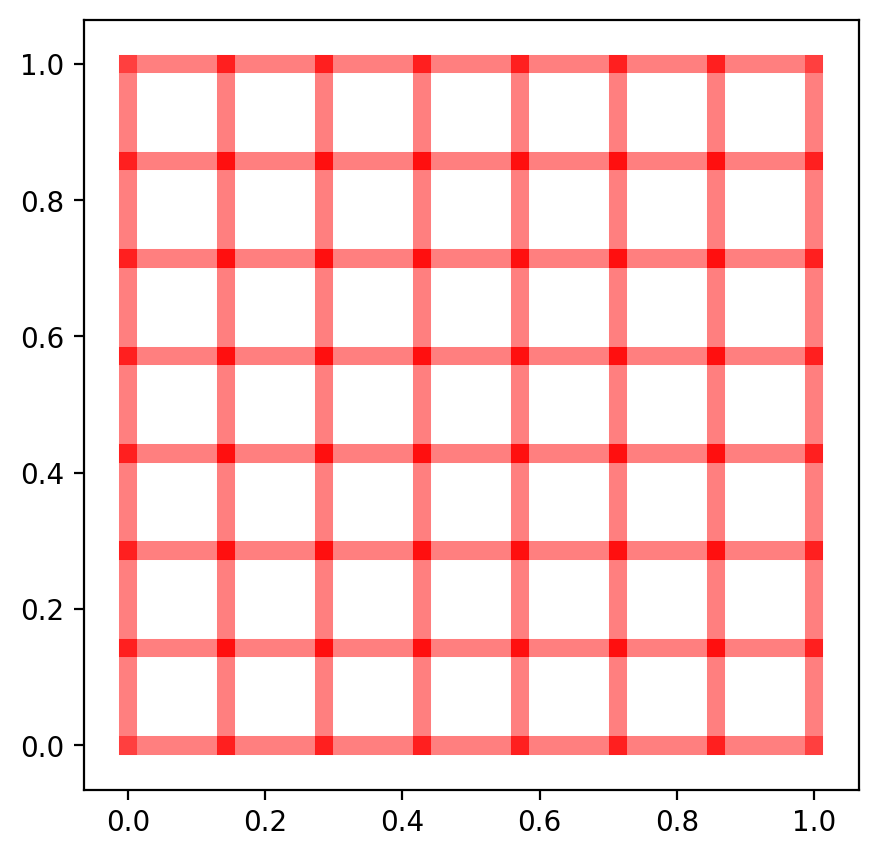

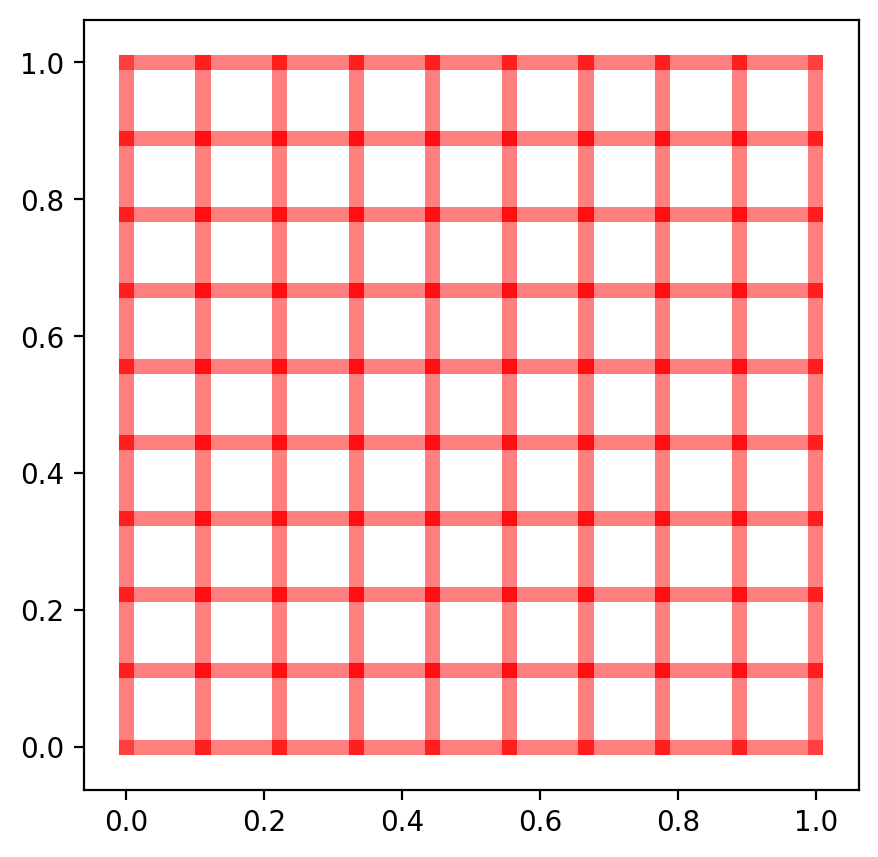

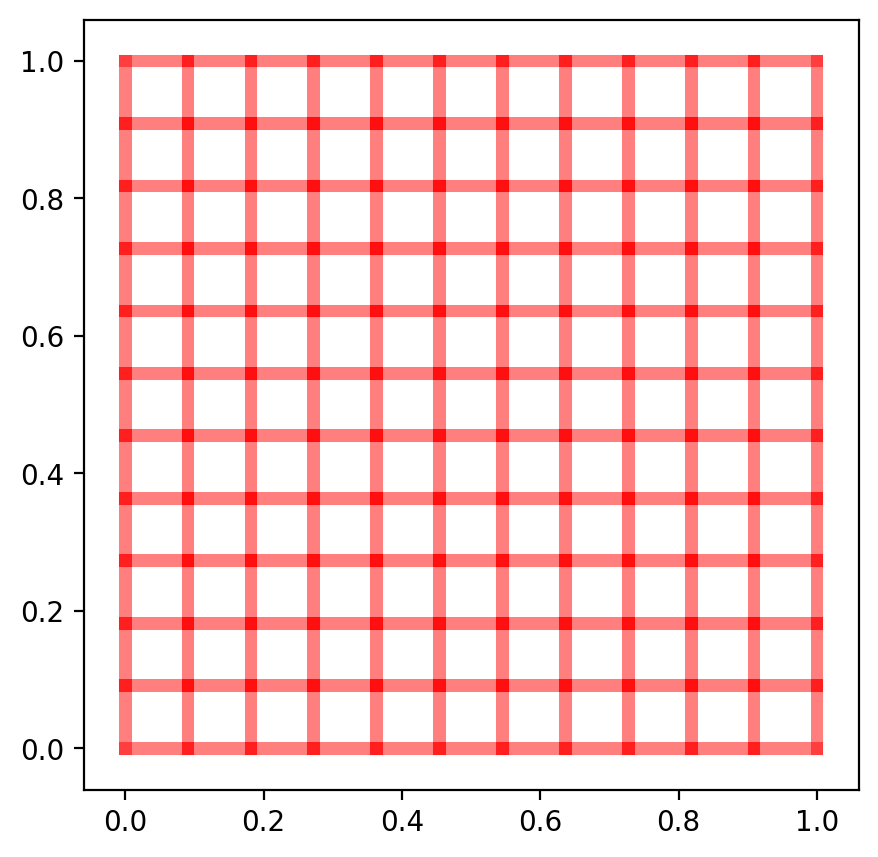

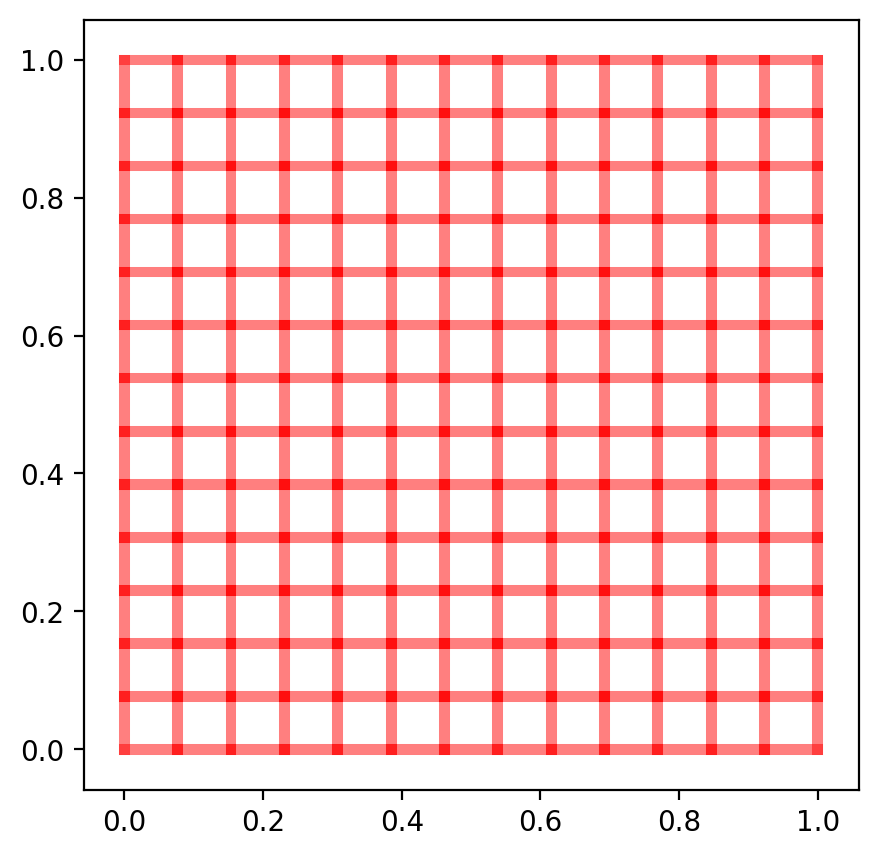

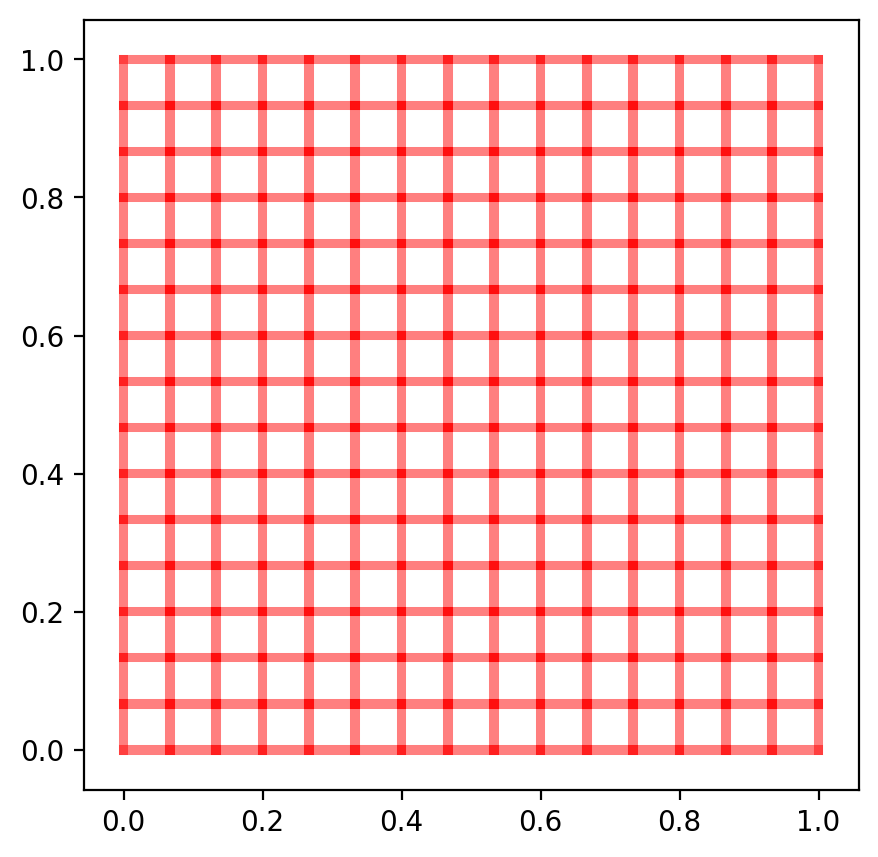

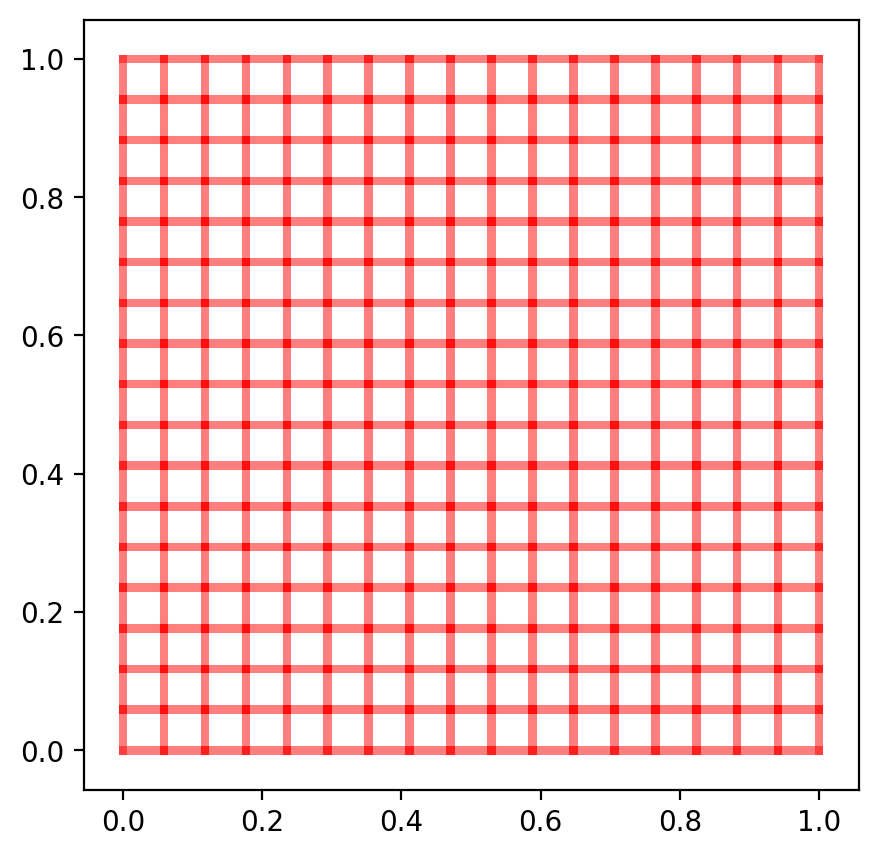

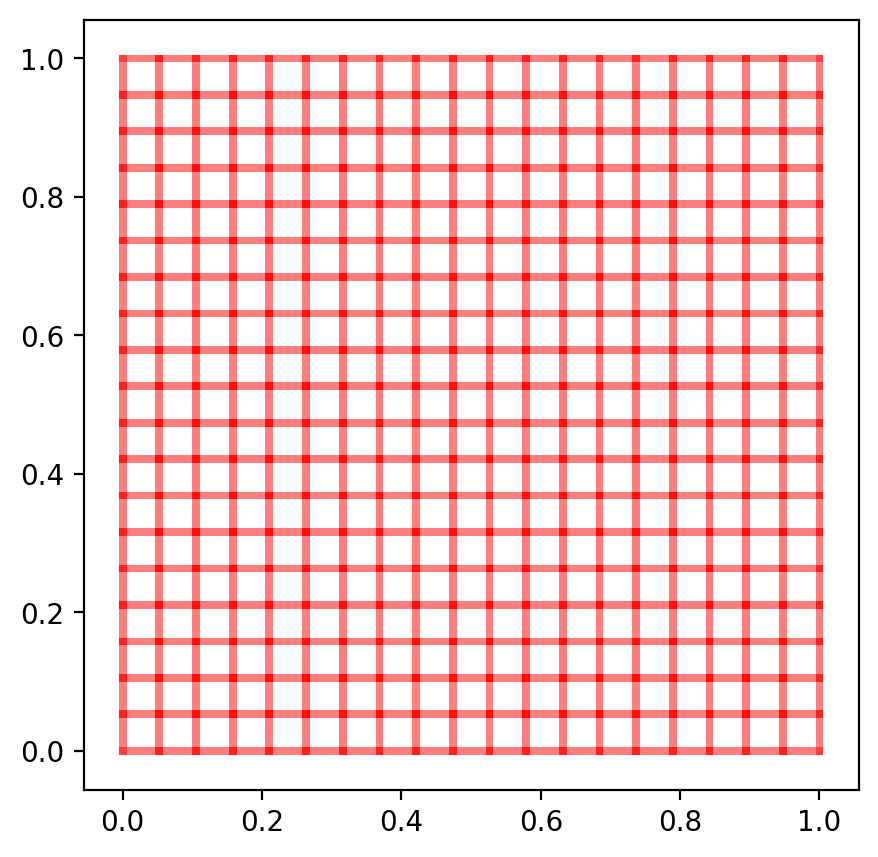

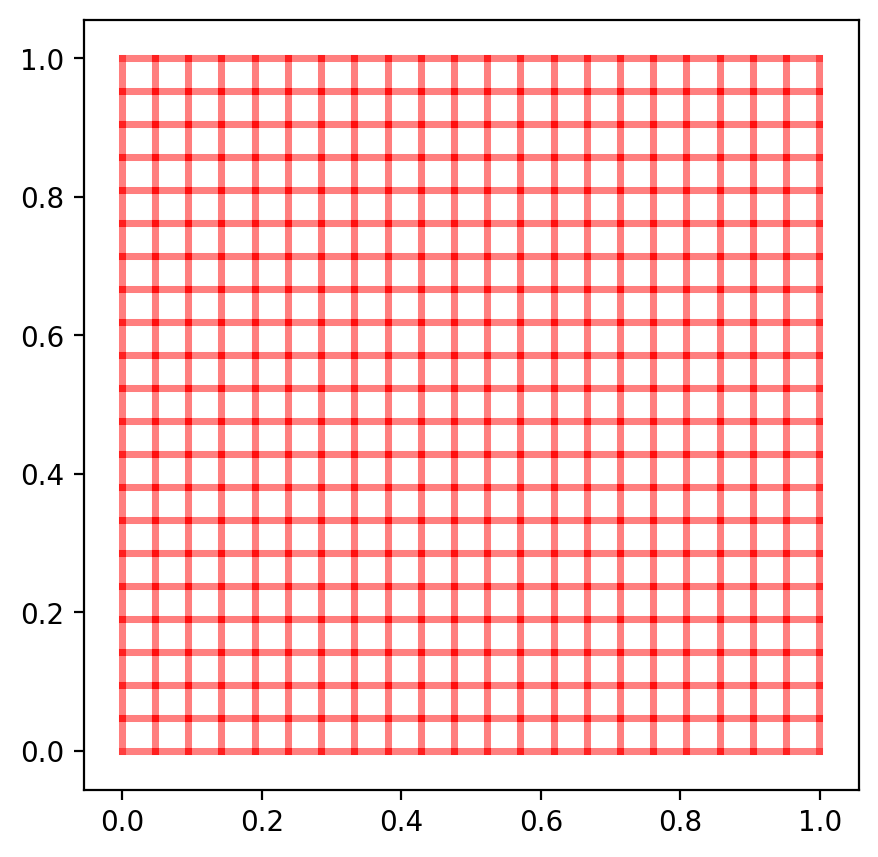

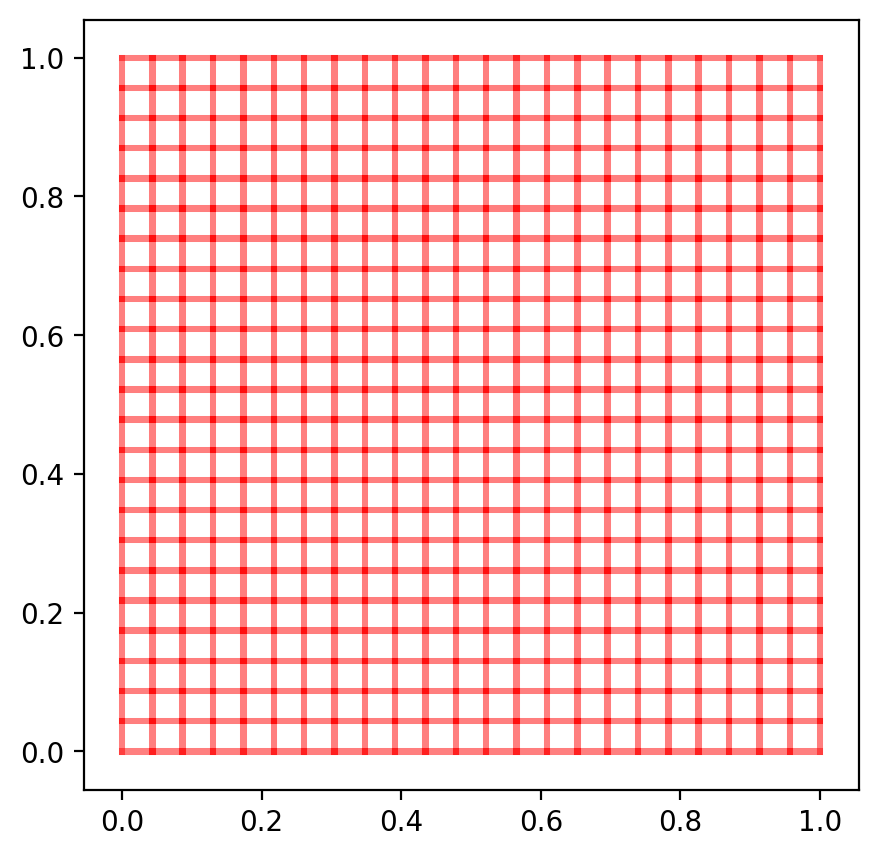

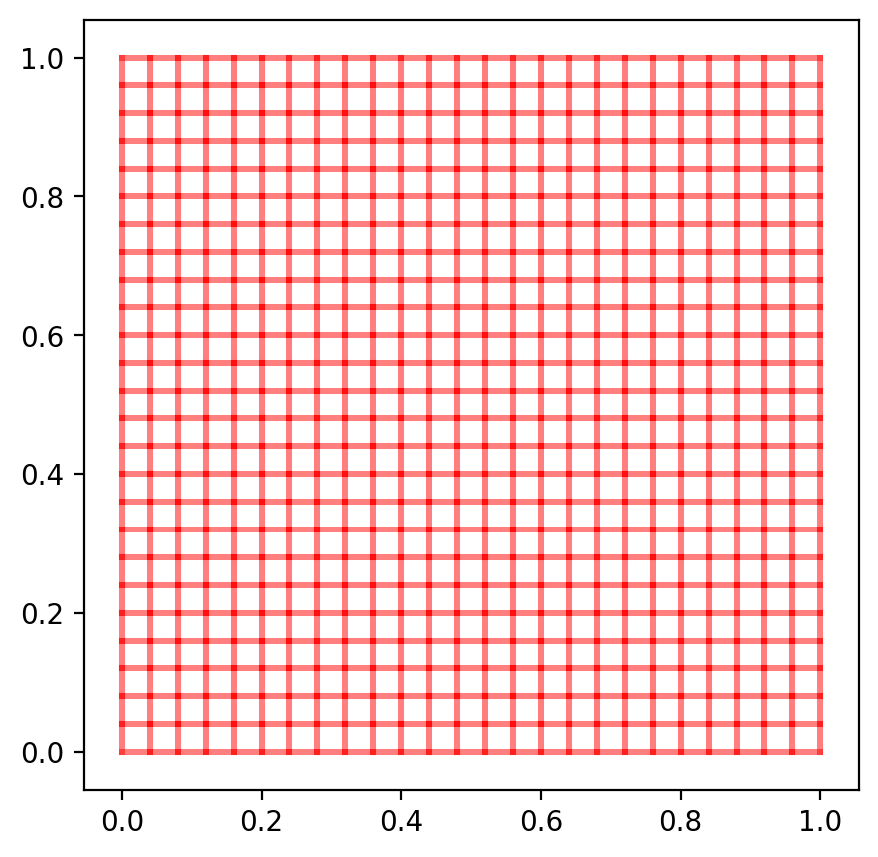

In [ ]:
def generate_square(sl_points,  sl_edges, keep_frac, thickness):
    sl_edges_tuple = [tuple(e) for e in sl_edges]
    #boundary edges where x = 0 or x = 1 or y = 0 or y = 1

    sl_boundary_edges = []
    for e in sl_edges_tuple:
        if sl_points[e[0]][0] == 0 or sl_points[e[0]][0] == 1 or sl_points[e[0]][1] == 0 or sl_points[e[0]][1] == 1 or sl_points[e[1]][0] == 0 or sl_points[e[1]][0] == 1 or sl_points[e[1]][1] == 0 or sl_points[e[1]][1] == 1:
            sl_boundary_edges.append(e)

    #random_edges
    sl_random_edges = []
    for e in sl_edges_tuple:
        if e in sl_boundary_edges:
            sl_random_edges.append(e)
        elif random.random() < keep_frac:
            sl_random_edges.append(e)
    #random_edges = [e for e in edges_tuple if random.random() < 0.99]

    sl_lcc_edges = filter_largest_component_from_edges(sl_random_edges)

    structure, area = square_lattice_edge_thickness(sl_lcc_edges, sl_points, thickness = thickness)

    return structure, area


adjustment = { 3:-0.0028, 5:-0.0011, 7:-0.00055,
             9:-0.0003, 11:-0.00015, 13:-0.0001,
             15:-0.00005, 17:-0.00002, 19:0.0000,
             21:0.00001, 23:0.00002, 25:0.00003}


avg_thickness =  0.0106
for u, p in unit_cells_sq.items():
    sl_points, sl_edges = p['pts'], p['edges']
    avg_thickness = p['avg_thickness'] + adjustment[u]
    
    structure, area = generate_square(sl_points,  sl_edges, keep_frac=1, thickness= avg_thickness)
    #print(area,keep, avg_thickness, replicate)


    new_area = area - len(sl_edges)*2*(avg_thickness**2)+len(sl_points)*(avg_thickness**2)
    print(round(new_area,4))

    thickness_string = str(round(avg_thickness,3)).replace(r'.', r'p')
    file_name = 'square_'+str(int(u))+'_th_'+str(thickness_string)+'_fixed_d'+ str(round(new_area,2)).replace('.','p') #'_' + str(removal) +'pct_' + str(replicate)

    print(file_name)

    path = r"./"
            
    structure_list = []
    for k,v in structure.items():
        for vv in v:
            structure_list.append(vv)

    structure_list = np.array(structure_list)


    f_x_max = structure_list[:,0].max()
    f_y_max = structure_list[:,1].max()

    f_x_min = structure_list[:,0].min()
    f_y_min = structure_list[:,1].min()

    save_stl(structure, out_plane_thickness = .25, name = path+file_name+'.stl', f_x_max=f_x_max, f_y_max = f_y_max, f_x_min=f_x_min, f_y_min = f_y_min, frame_thickness = 0.05) 
    
    #save the polygon_dict to a pickle file
    with open(path+'input_'+file_name + '.pkl', 'wb') as f:
        pickle.dump(structure, f, protocol=2)